# Cyber Security Exercise

This notebook is a minimal exploration, preprocessing and, modelling for the 15/Feb portion of the IDS 2018 Intrusion CSVs (CSE-CIC-IDS2018) dataset. I have prepared it with the following assumptions and constraints.

* The rest of the dataset was not used in any manner to inform the work in this notebook.
* It is performed within the reasonable time constraint for an exercise, and as such it is lacking in many respects, by no means representative of how productioning a machine learning pipeline should be done, and any semblance of sound design should not inform any design decisions for production machine learning.

With that in mind let's go ahead, delve into the dataset.



# Loading the data

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/02152018-threats/02-15-2018.csv


In [2]:
import pandas as pd
import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

In [3]:
random_state = 5
np.random.seed(random_state)

In [4]:
data = pd.read_csv('../input/02152018-threats/02-15-2018.csv')

In [5]:
traffic_df = data #Keep original loaded file unchanged

# Data exploration

## Check all the columns in the dataset

In [6]:
with pd.option_context('display.max_columns', None,):
    print(traffic_df.head(10))

   Dst Port  Protocol            Timestamp  Flow Duration  Tot Fwd Pkts  \
0         0         0  15/02/2018 08:25:18      112641158             3   
1        22         6  15/02/2018 08:29:05       37366762            14   
2     47514         6  15/02/2018 08:29:42            543             2   
3         0         0  15/02/2018 08:28:07      112640703             3   
4         0         0  15/02/2018 08:30:56      112640874             3   
5         0         0  15/02/2018 08:33:45      112640945             3   
6        80         6  15/02/2018 08:37:04         179213             3   
7        80         6  15/02/2018 08:37:04             14             2   
8         0         0  15/02/2018 08:36:34      112641627             3   
9        22         6  15/02/2018 08:39:45       25524814            17   

   Tot Bwd Pkts  TotLen Fwd Pkts  TotLen Bwd Pkts  Fwd Pkt Len Max  \
0             0                0                0                0   
1            12             2168  

## Check for the number of classes

The data set has three classes and is highly imbalanced towards the Benign label. We will explore ways to handle the imbalance below.

In [7]:
traffic_df[['Label']].groupby(['Label']).size()

Label
Benign                   996077
DoS attacks-GoldenEye     41508
DoS attacks-Slowloris     10990
dtype: int64

## Check for NaN's

Only one column has NaN vlaues. 

In [8]:
columns_with_NaNs = traffic_df.isna().any()
traffic_df[columns_with_NaNs.index[columns_with_NaNs]]

,Flow Byts/s
0,0.000000e+00
1,1.381174e+02
2,1.178637e+05
3,0.000000e+00
4,0.000000e+00
...,...
1048570,1.409091e+06
1048571,3.090552e+00
1048572,3.148163e+00
1048573,3.090519e+00


See how prevalent are the NaNs.

In [9]:
columns_with_NaNs_df = traffic_df[columns_with_NaNs.index[columns_with_NaNs]]
columns_with_NaNs_df[columns_with_NaNs_df.isna().any(axis=1)]

,Flow Byts/s
54581,NaN
54738,NaN
55515,NaN
55620,NaN
55760,NaN
...,...
1047874,NaN
1048083,NaN
1048094,NaN
1048334,NaN


### Check which classes NaNs are tied to

Fortunately, the minority classes do not suffer from NaN values. Whatever strategy we use for imputation or omission, having NaNs in the majority class will make it more statistically sound. However, in an evolving machine learning project this assumption can change, and an imputation strategy needs to be implemented.

In [10]:
traffic_df[columns_with_NaNs_df.isna().any(axis=1)][['Label']].groupby(['Label']).count()

""
Label
Benign


## Check for infinite values

There are 4921 NaNs + 3106 (+/-) inf in Flow Byts/s, and 8027 (+/-) inf in Flow Pkts/s

In [11]:
columns_with_infs = np.isinf(traffic_df.select_dtypes(include=[np.number])).any()
inf_df = traffic_df[columns_with_infs.index[columns_with_infs]]
np.isinf(inf_df).sum()

Flow Byts/s    3106
Flow Pkts/s    8027
dtype: int64

In [12]:
index_with_label = inf_df.columns
index_with_label = index_with_label.append(pd.Index(['Label']))
traffic_df[index_with_label]

,Flow Byts/s,Flow Pkts/s,Label
0,0.000000e+00,0.026633,Benign
1,1.381174e+02,0.695806,Benign
2,1.178637e+05,3683.241252,Benign
3,0.000000e+00,0.026633,Benign
4,0.000000e+00,0.026633,Benign
...,...,...,...
1048570,1.409091e+06,136363.636364,Benign
1048571,3.090552e+00,0.109724,Benign
1048572,3.148163e+00,0.111769,Benign
1048573,3.090519e+00,0.109723,Benign


### Check the classes to which inf's are tied

Only the majority class has inf's. This will make the job of imputation/omission more effective for the same reasons mentioned above. Like with NaN's however, in an evolving machine learning project this assumption can change, and an imputation strategy needs to be implemented.

In [13]:
traffic_df[[inf_df.columns[0],'Label']][np.isinf(inf_df[inf_df.columns[0]])].groupby(['Label']).count()

,Flow Byts/s
Label,
Benign,3106


In [14]:
traffic_df[[inf_df.columns[1],'Label']][np.isinf(inf_df[inf_df.columns[1]])].groupby(['Label']).count()

,Flow Pkts/s
Label,
Benign,8027


## Check unique values in each column

In [15]:
column_unique_counts = traffic_df.nunique()
with pd.option_context('display.max_rows', None,):
    print(column_unique_counts)

Dst Port              21732
Protocol                  3
Timestamp             33862
Flow Duration        483970
Tot Fwd Pkts            694
Tot Bwd Pkts           1189
TotLen Fwd Pkts        7717
TotLen Bwd Pkts       22673
Fwd Pkt Len Max        1450
Fwd Pkt Len Min         142
Fwd Pkt Len Mean      25680
Fwd Pkt Len Std       46964
Bwd Pkt Len Max        1172
Bwd Pkt Len Min         286
Bwd Pkt Len Mean      38049
Bwd Pkt Len Std       46792
Flow Byts/s          542155
Flow Pkts/s          501270
Flow IAT Mean        501083
Flow IAT Std         464613
Flow IAT Max         392002
Flow IAT Min         116630
Fwd IAT Tot          434593
Fwd IAT Mean         444703
Fwd IAT Std          353644
Fwd IAT Max          377347
Fwd IAT Min          148883
Bwd IAT Tot          329725
Bwd IAT Mean         335604
Bwd IAT Std          325005
Bwd IAT Max          262596
Bwd IAT Min          124886
Fwd PSH Flags             2
Bwd PSH Flags             1
Fwd URG Flags             1
Bwd URG Flags       

## Check which columns have 10 or less unique values
We need this step for two things, first it happens often that some columns have only one value, therefore they need to be left out from the training. Another thing is that features with few unique values often indicate categorical variables. Notice that this method misses the 'Dst Port' feature, which is categorical.

In [16]:
for i in range(1,11):
    df_with_n_uniques = traffic_df[column_unique_counts.index[column_unique_counts == i]]
    if not df_with_n_uniques.empty:
        num_of_columns = len(df_with_n_uniques.columns)
        print(f"\n--- {num_of_columns} columns have {i} unique values:")
        for c in df_with_n_uniques.columns:
            print("\n",df_with_n_uniques[c].value_counts())
    else:
        print(f"\nNo columns have {i} unique values.")


--- 10 columns have 1 unique values:

 0    1048575
Name: Bwd PSH Flags, dtype: int64

 0    1048575
Name: Fwd URG Flags, dtype: int64

 0    1048575
Name: Bwd URG Flags, dtype: int64

 0    1048575
Name: CWE Flag Count, dtype: int64

 0    1048575
Name: Fwd Byts/b Avg, dtype: int64

 0    1048575
Name: Fwd Pkts/b Avg, dtype: int64

 0    1048575
Name: Fwd Blk Rate Avg, dtype: int64

 0    1048575
Name: Bwd Byts/b Avg, dtype: int64

 0    1048575
Name: Bwd Pkts/b Avg, dtype: int64

 0    1048575
Name: Bwd Blk Rate Avg, dtype: int64

--- 8 columns have 2 unique values:

 0    994848
1     53727
Name: Fwd PSH Flags, dtype: int64

 0    1042423
1       6152
Name: FIN Flag Cnt, dtype: int64

 0    994848
1     53727
Name: SYN Flag Cnt, dtype: int64

 0    984626
1     63949
Name: RST Flag Cnt, dtype: int64

 0    667441
1    381134
Name: PSH Flag Cnt, dtype: int64

 0    749074
1    299501
Name: ACK Flag Cnt, dtype: int64

 0    998441
1     50134
Name: URG Flag Cnt, dtype: int64

 0    9

# Preprocessing (First round)

## Handling NaNs and inf's

The majority class 'Benign' comprises almost 95% of the labels. In a dataset of more than a million datapoints, we can safely drop the rows that contain NaNs and (+/-) inf when they occur under the majority label 'Benign'. Note that in production the prediction pipeline needs to include a preprocessing stage to impute values to any anamolous quantities as they can occur in our incoming data stream.

In [17]:
datasize = traffic_df.shape[0]
labels = traffic_df[['Label']].groupby(['Label']).size().index
for label in labels:
    percentage = np.round(traffic_df[['Label']][traffic_df['Label'] == label].shape[0]/datasize*100,2)
    print(f'{label} comprises {percentage}% of the dataset.')

Benign comprises 94.99% of the dataset.
DoS attacks-GoldenEye comprises 3.96% of the dataset.
DoS attacks-Slowloris comprises 1.05% of the dataset.


In [18]:
with pd.option_context('mode.use_inf_as_na', True):
    traffic_df = traffic_df.dropna(how='any')
traffic_df.shape[0]

1040548

In [19]:
is_there_nan = traffic_df.isna().any().any()
is_there_nan

False

## Drop rows with one unique value

In [20]:
#Drop columns with 1 unique values
traffic_df = traffic_df[column_unique_counts.index[column_unique_counts != 1]]
traffic_df.nunique()

Dst Port          21723
Protocol              3
Timestamp         33860
Flow Duration    483969
Tot Fwd Pkts        694
                  ...  
Idle Mean        153947
Idle Std          99359
Idle Max         125263
Idle Min         134473
Label                 3
Length: 70, dtype: int64

## Convert Timestamp to proper datetime for easier handling

In [21]:
traffic_df['Timestamp'] = pd.to_datetime(traffic_df['Timestamp'],infer_datetime_format = True)
traffic_df['Timestamp'].dtype

dtype('<M8[ns]')

# Univariate analysis

Now that we have eleminated all the NaNs and inf's let's plot each feature against each class. This is an important step to check that everything is in accordance with our expectations.

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:218: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)


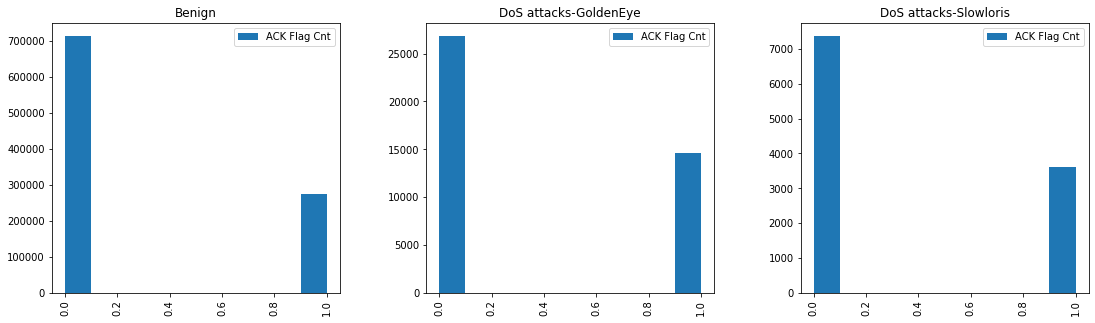

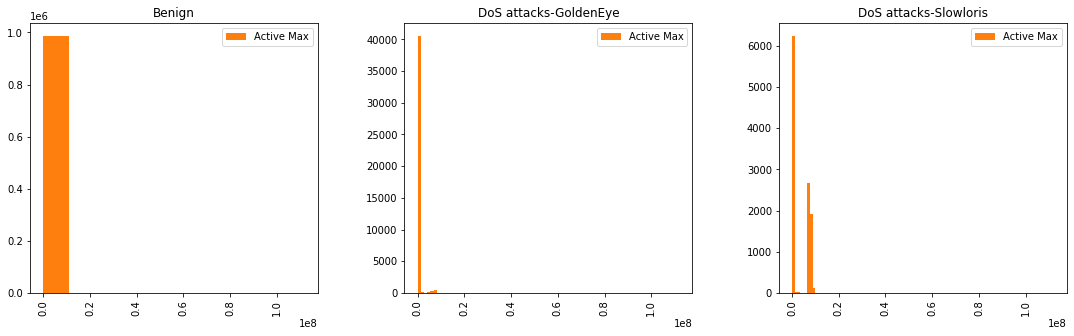

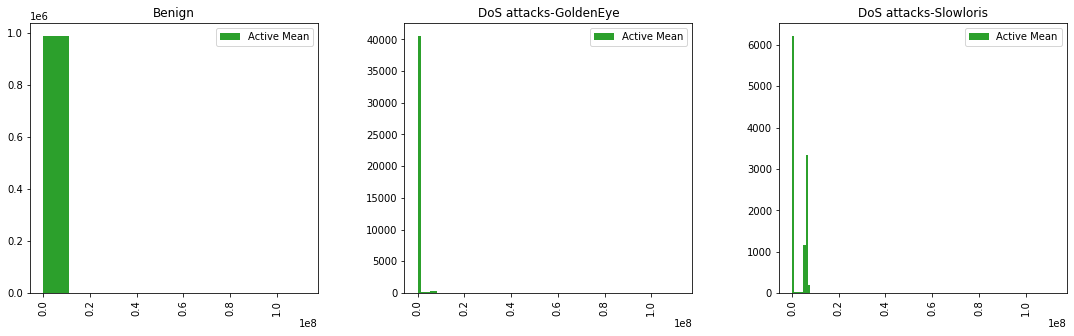

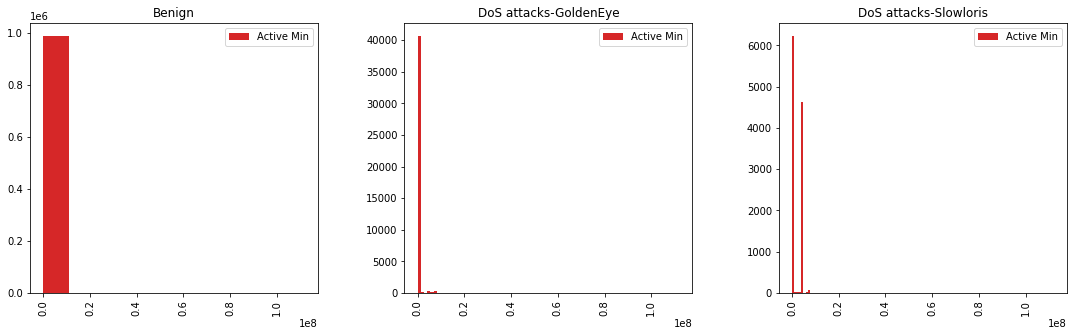

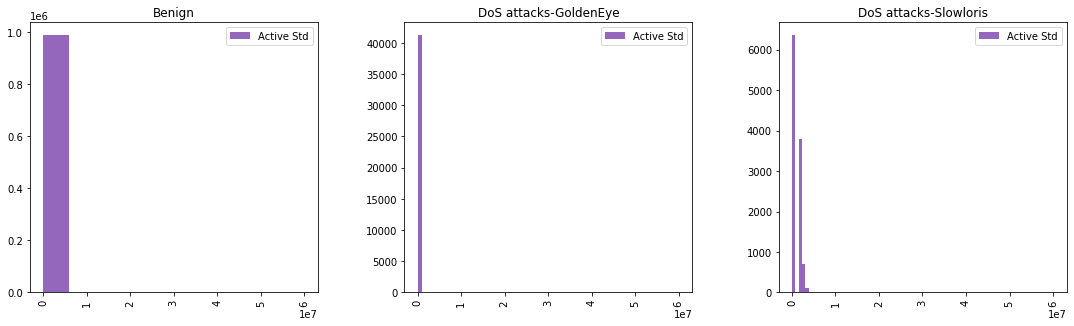

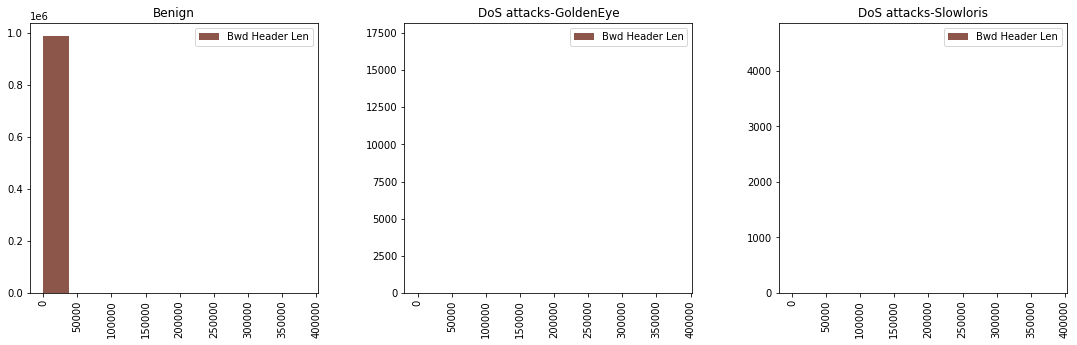

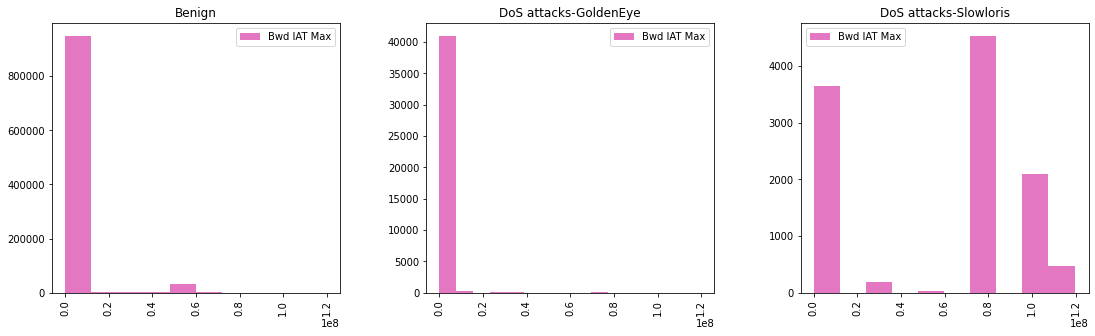

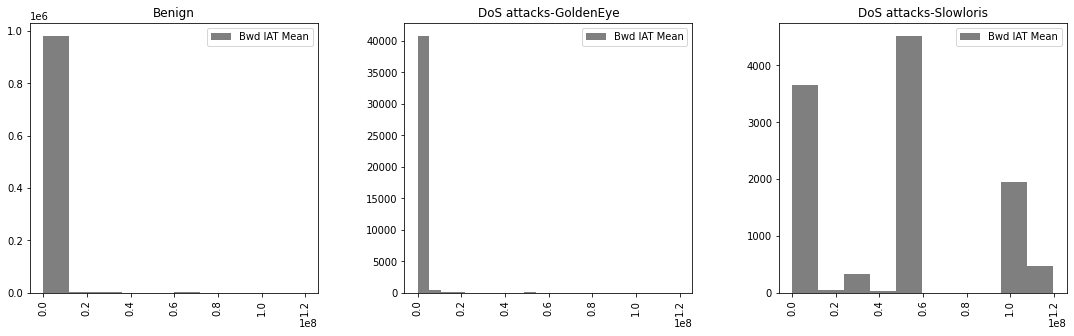

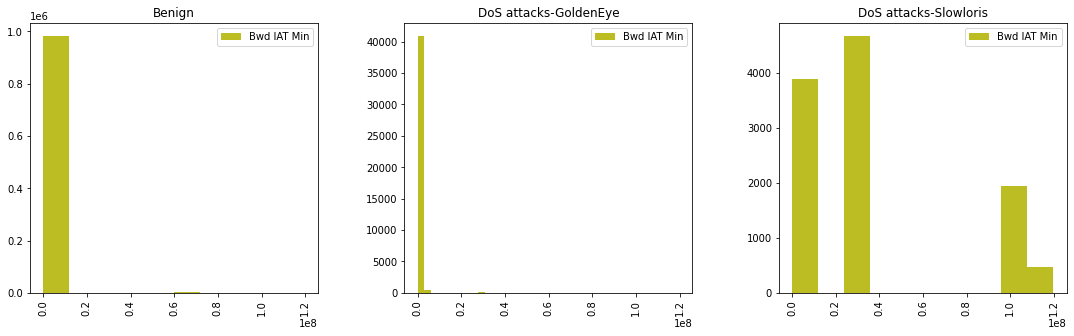

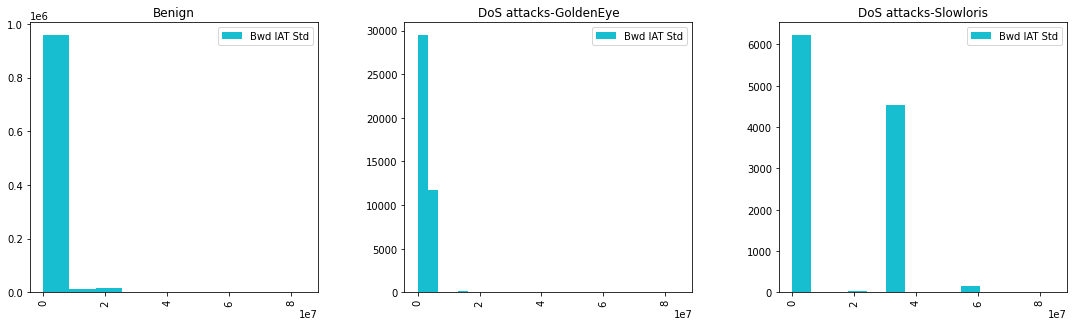

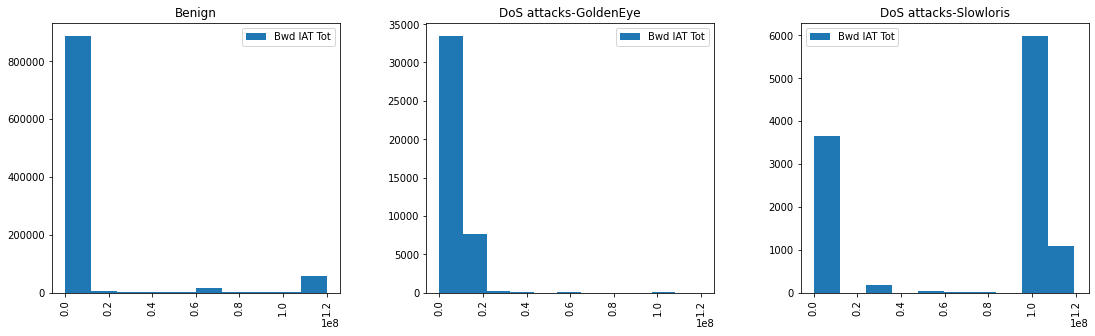

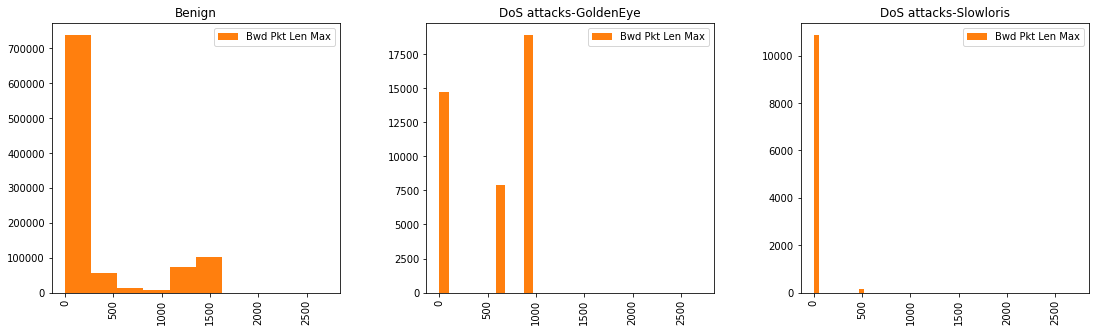

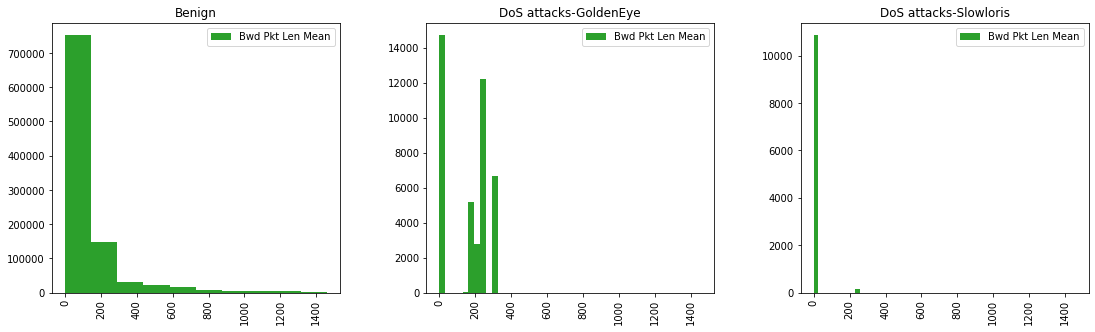

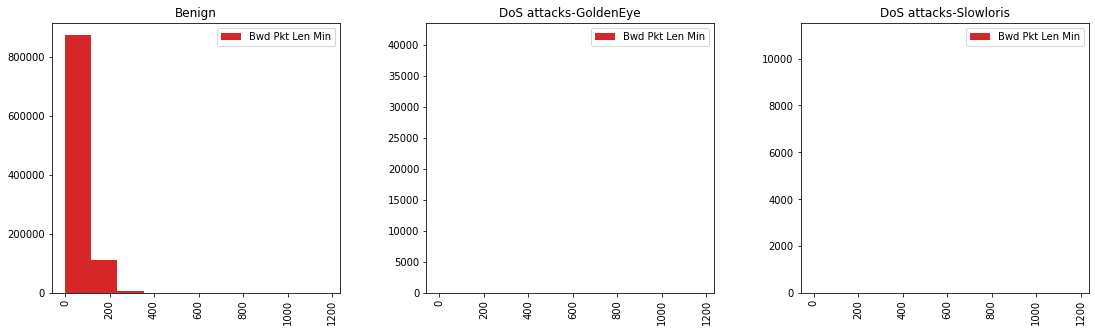

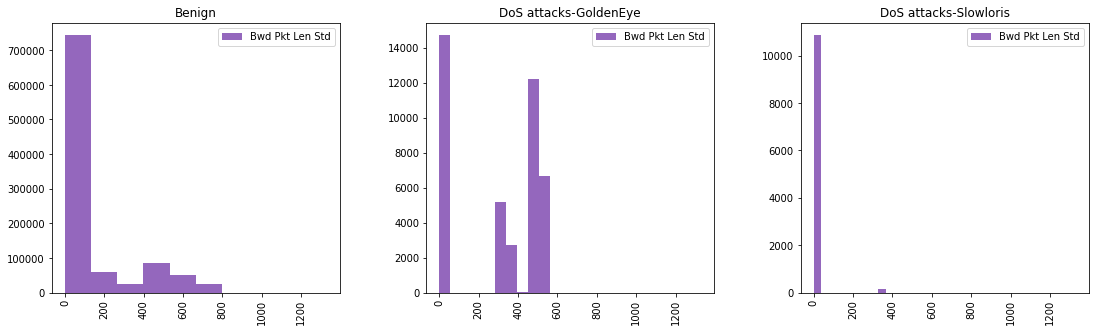

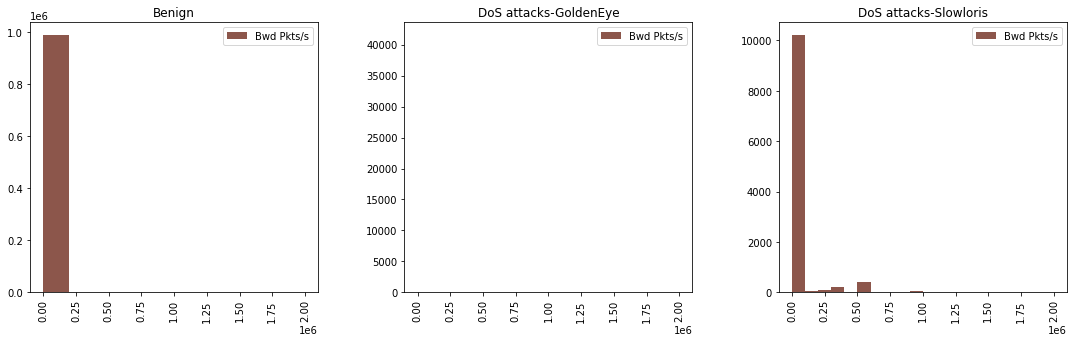

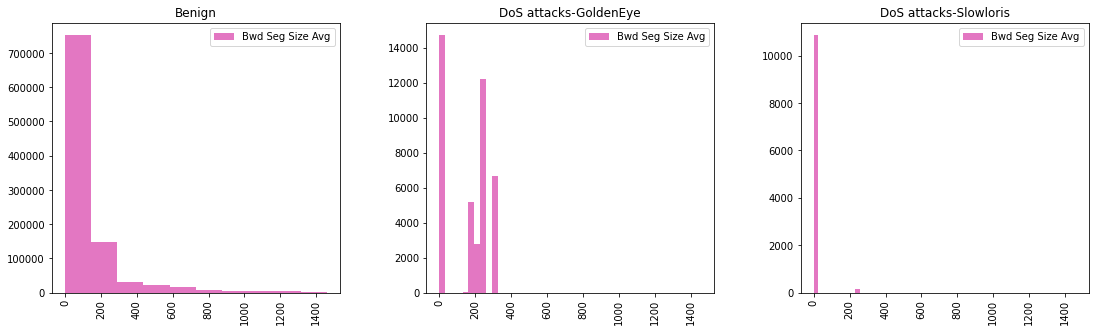

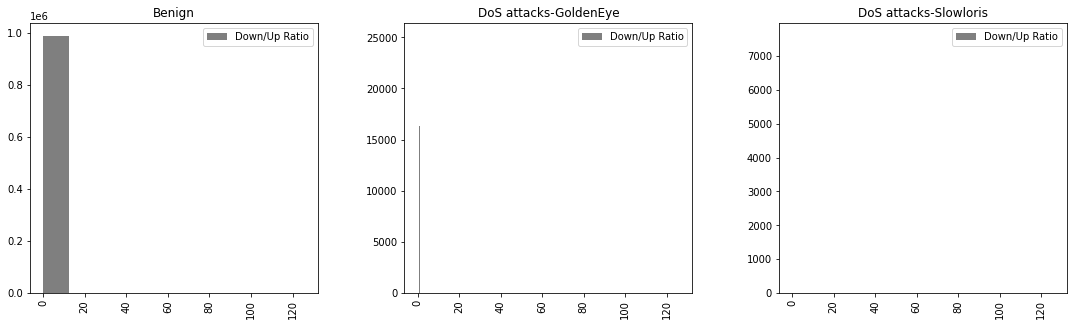

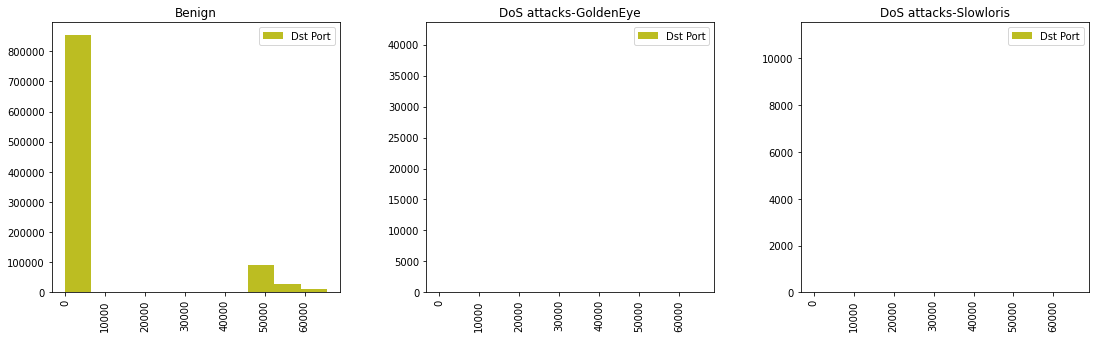

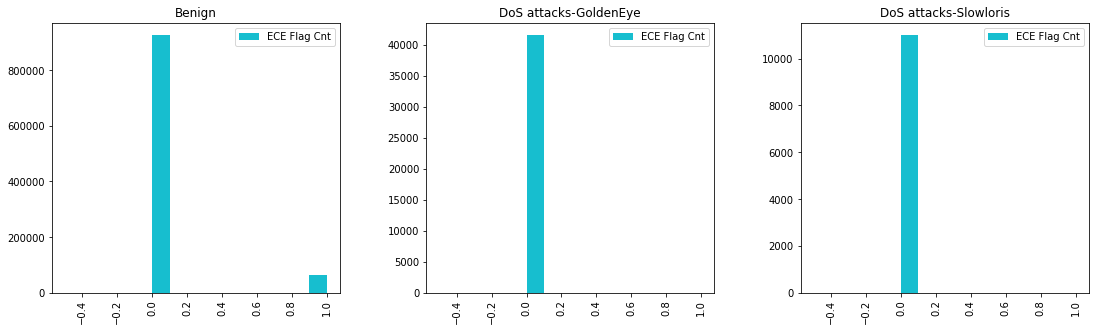

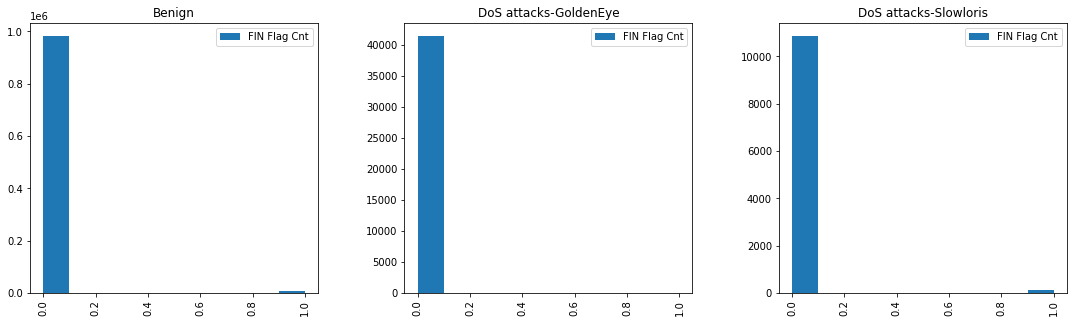

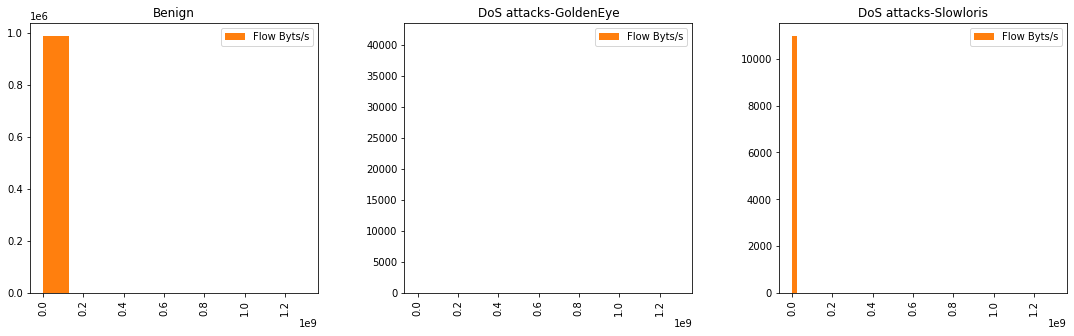

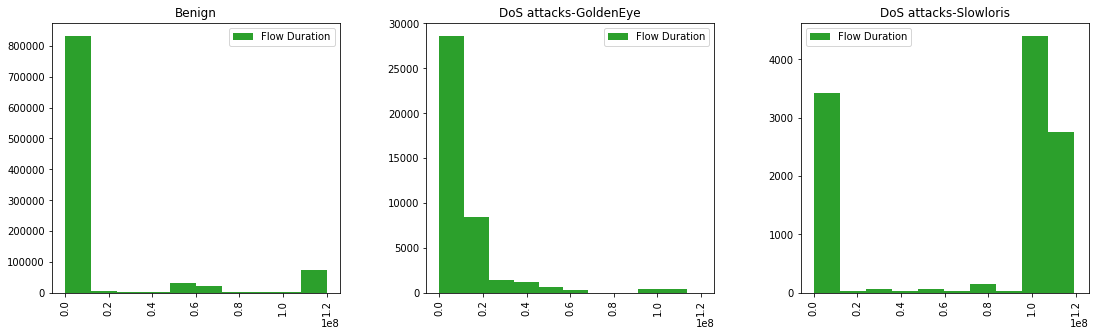

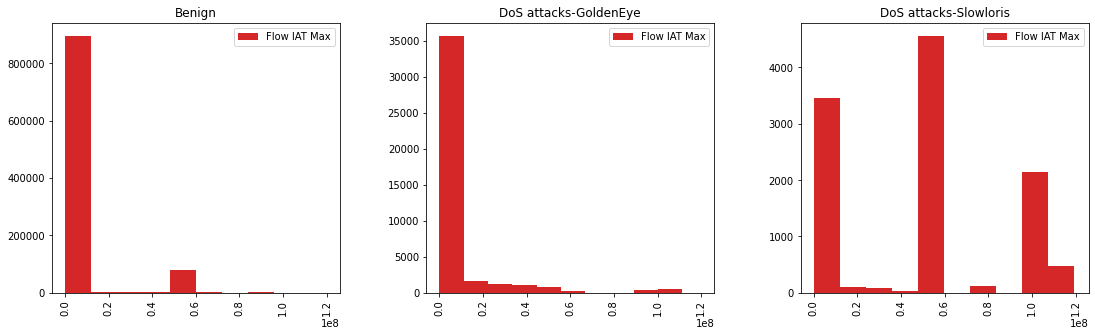

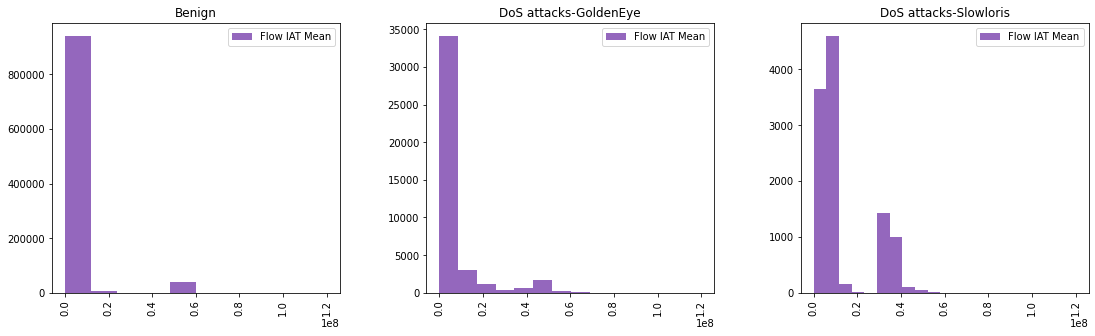

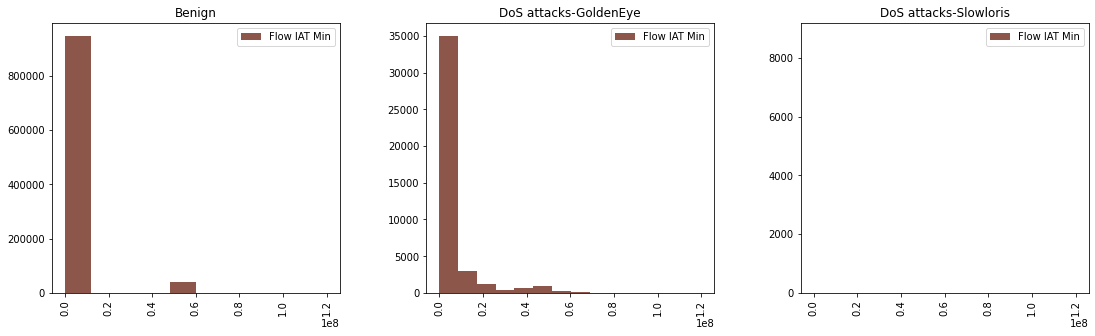

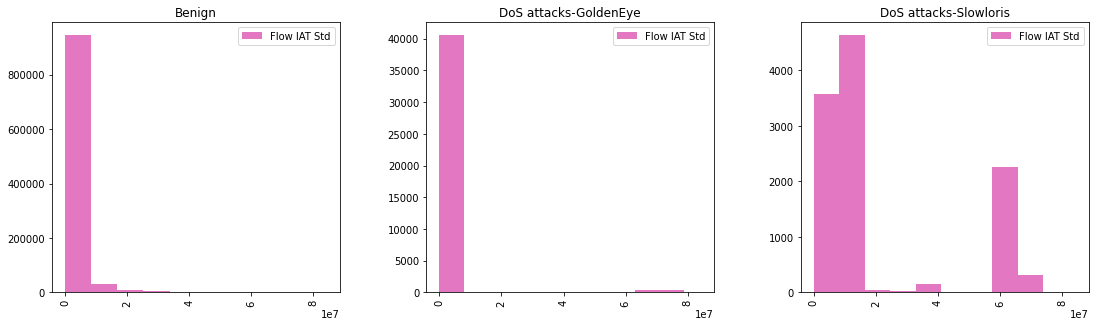

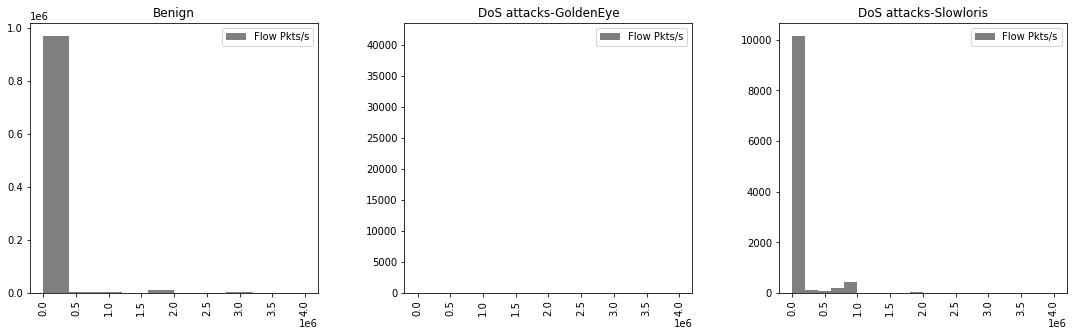

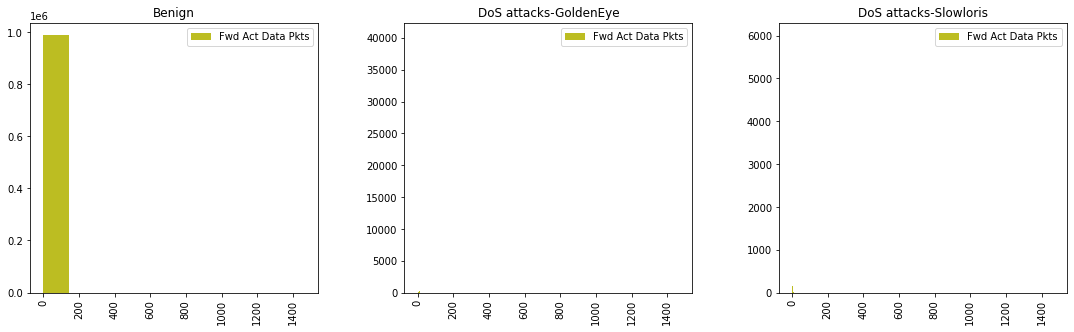

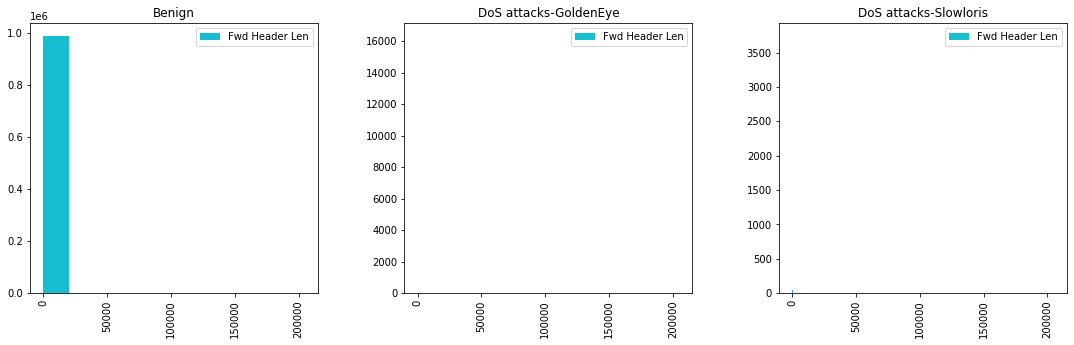

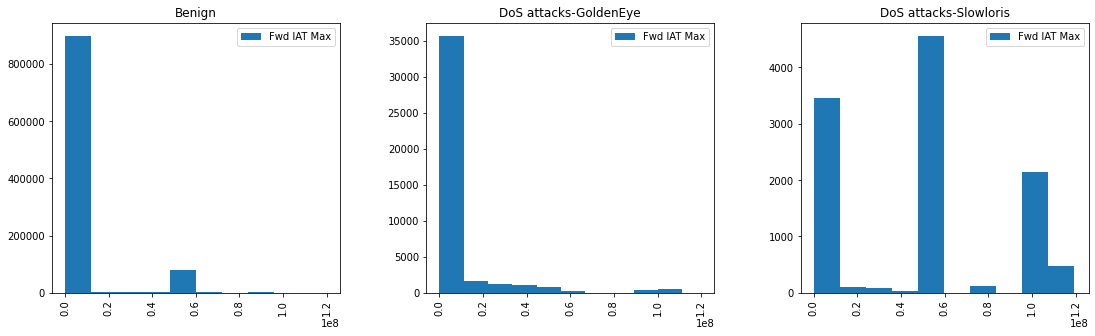

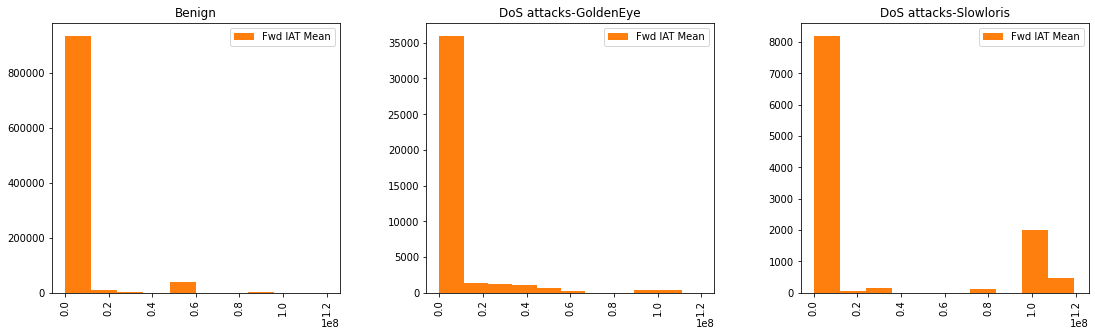

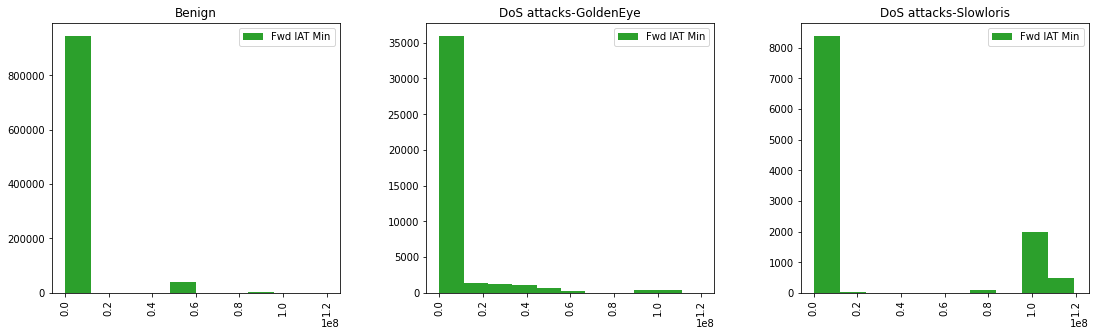

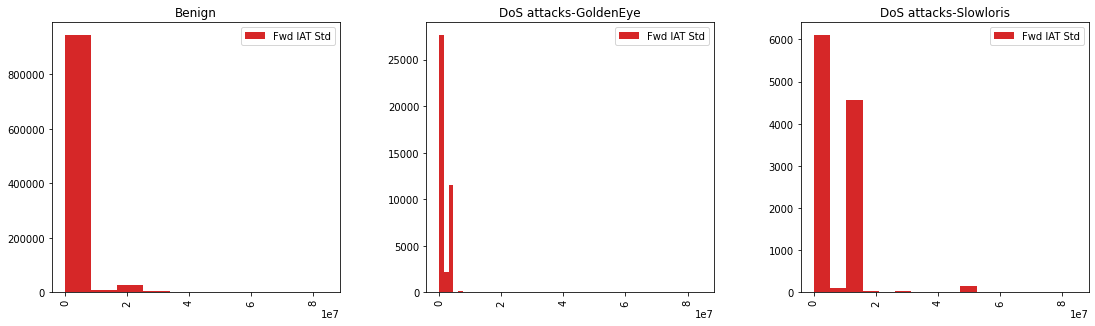

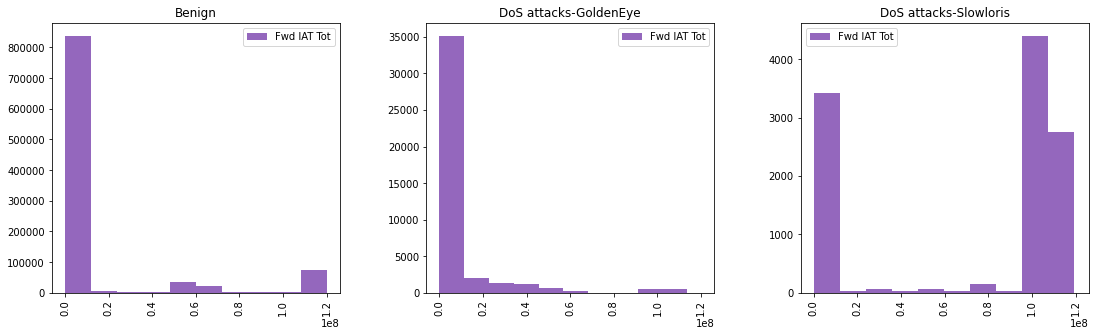

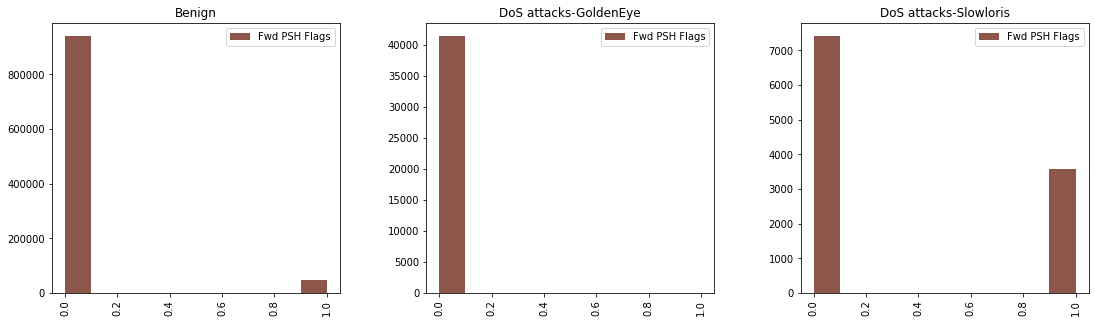

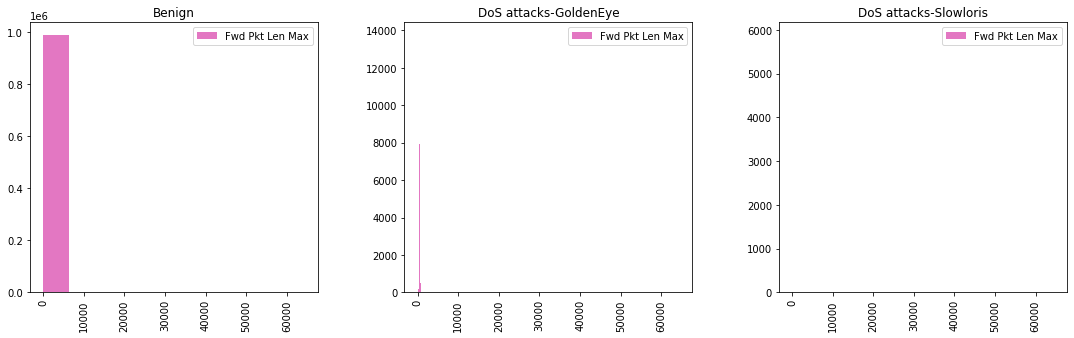

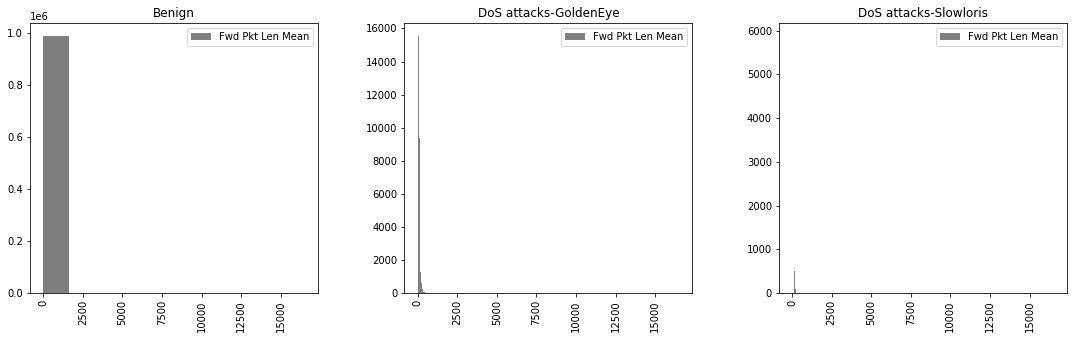

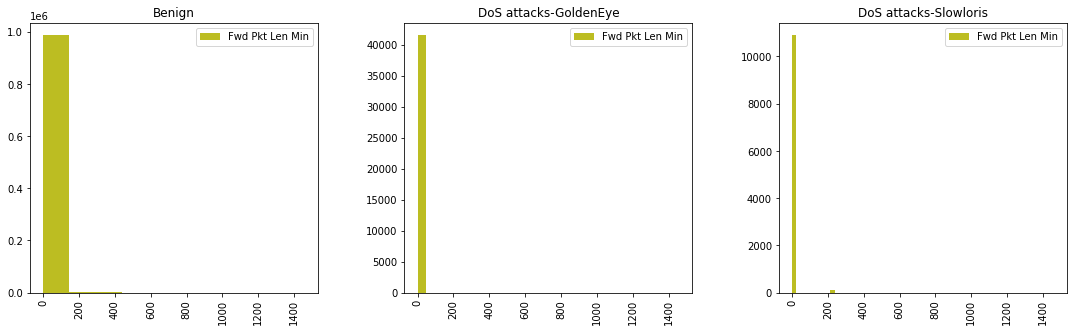

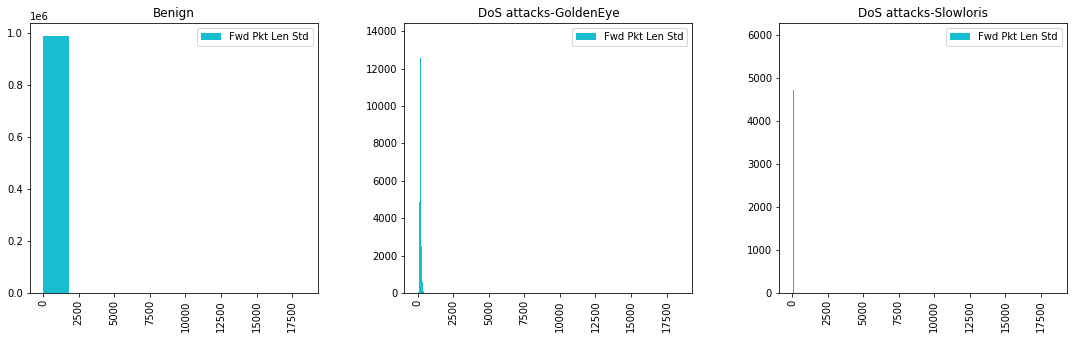

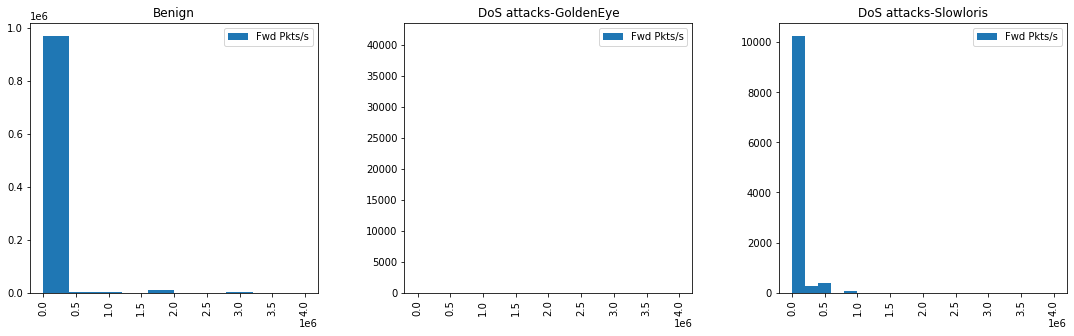

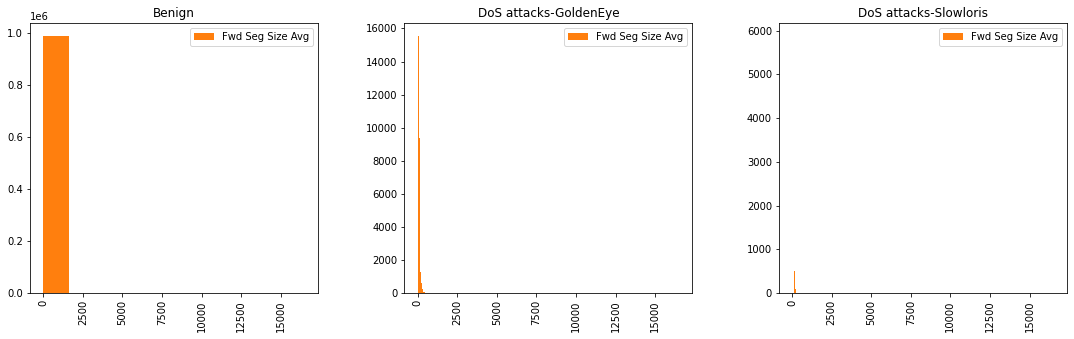

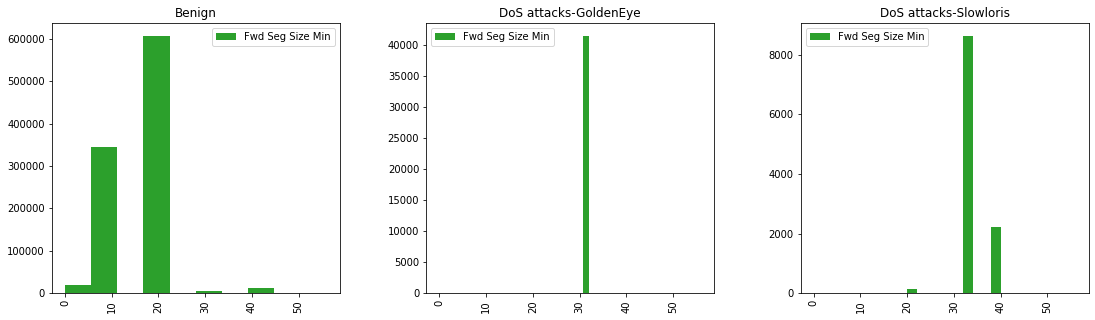

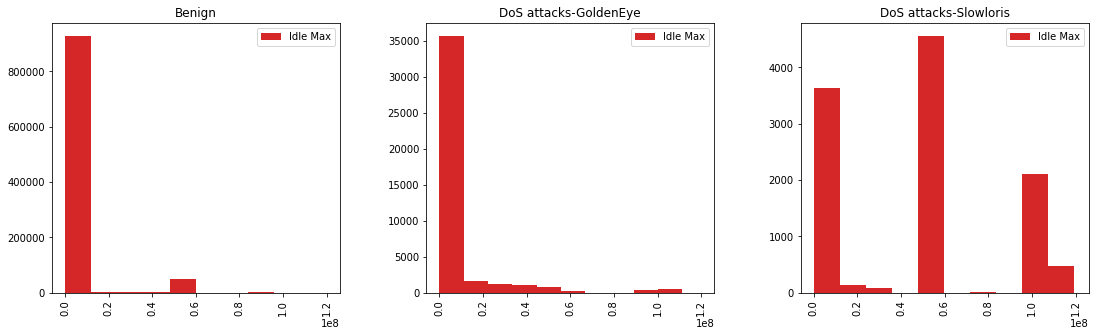

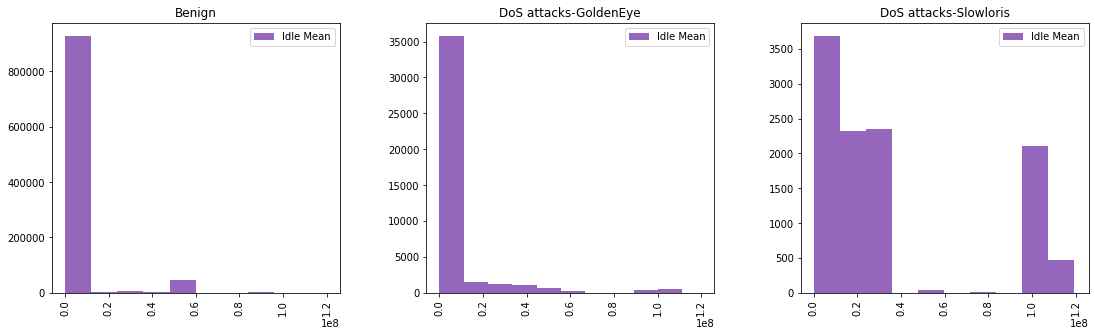

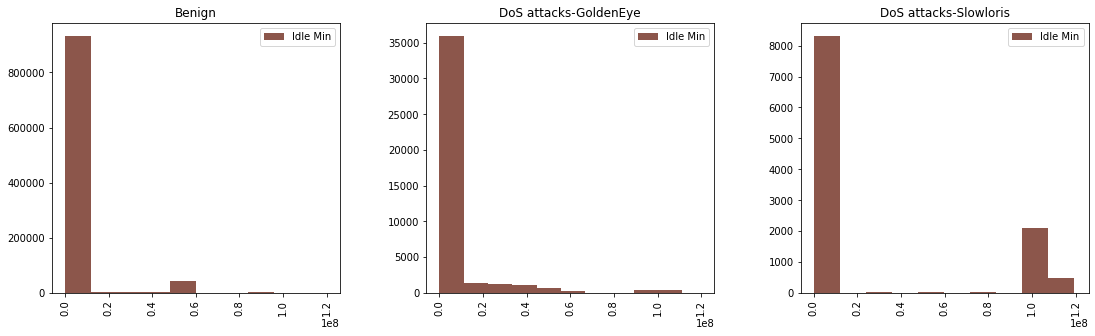

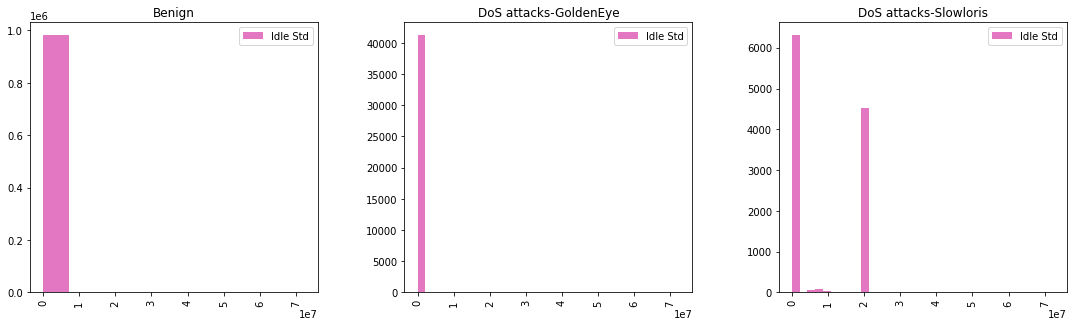

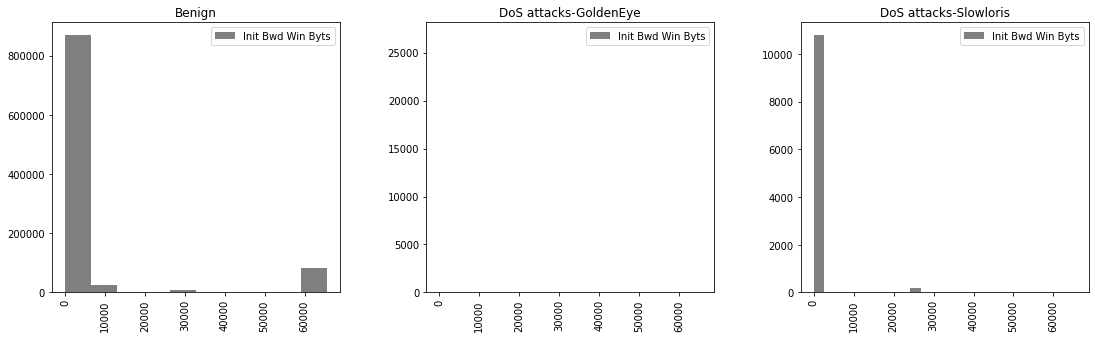

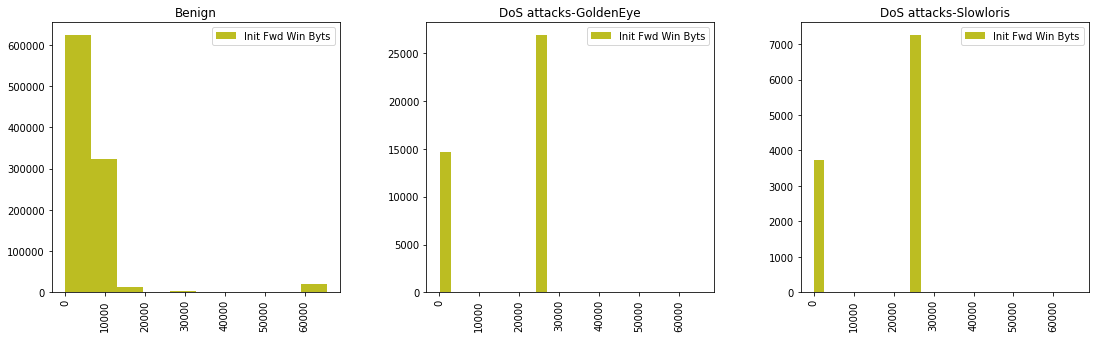

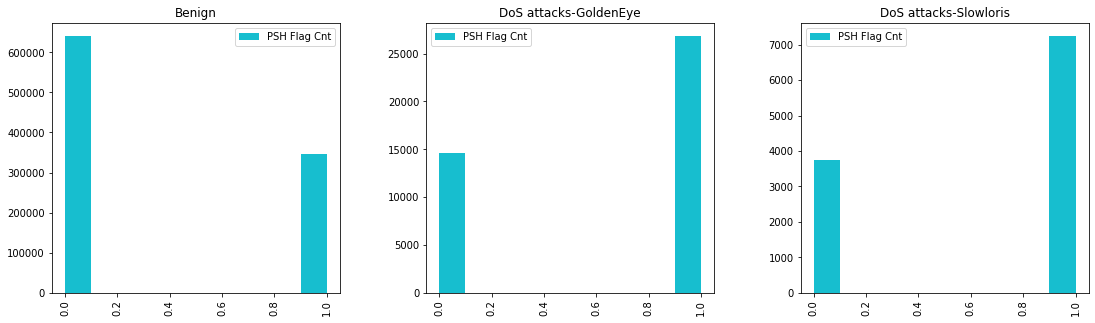

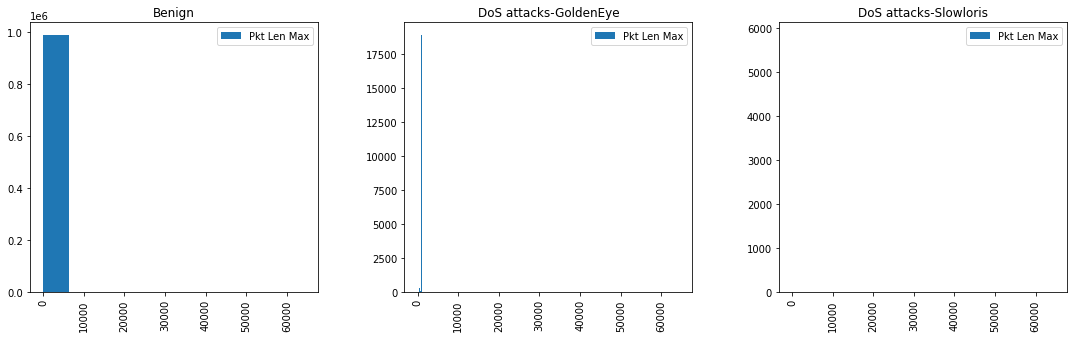

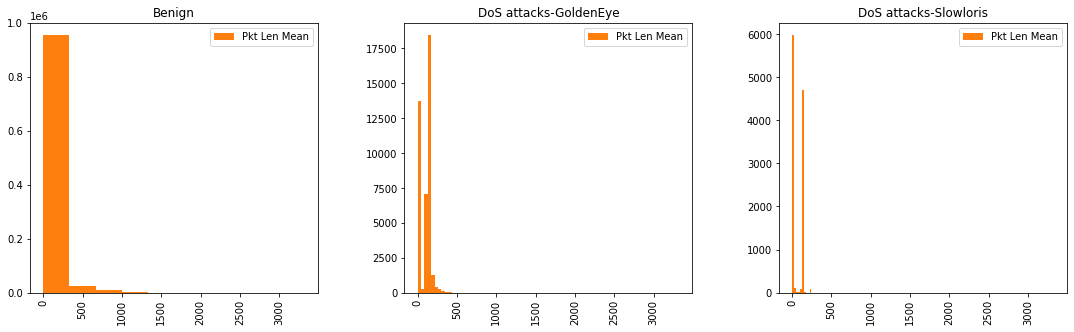

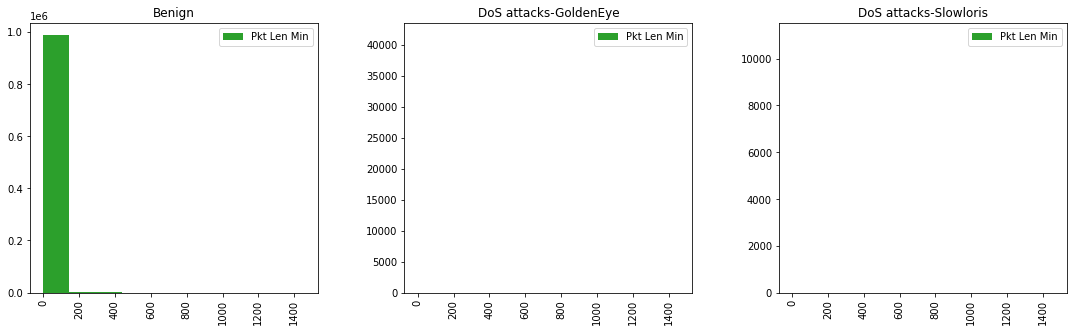

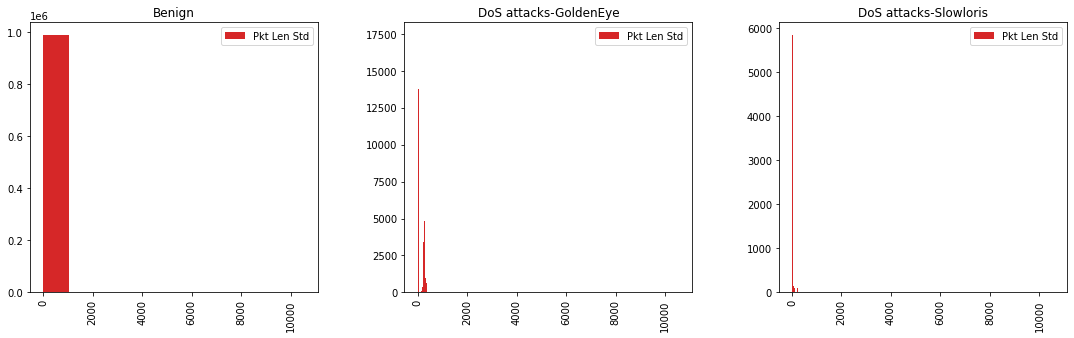

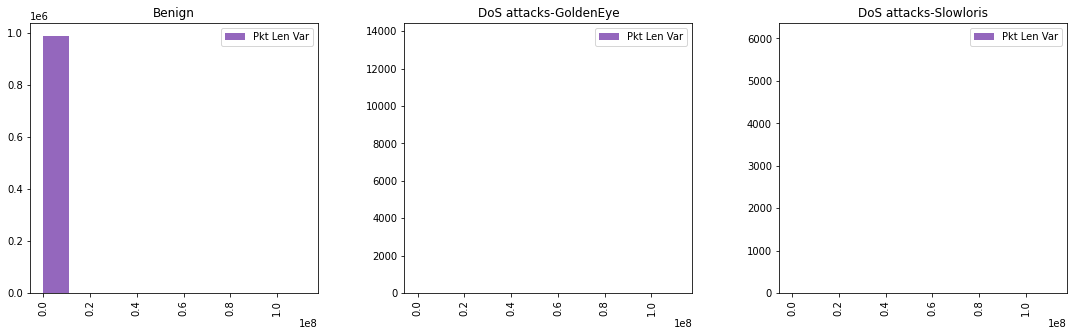

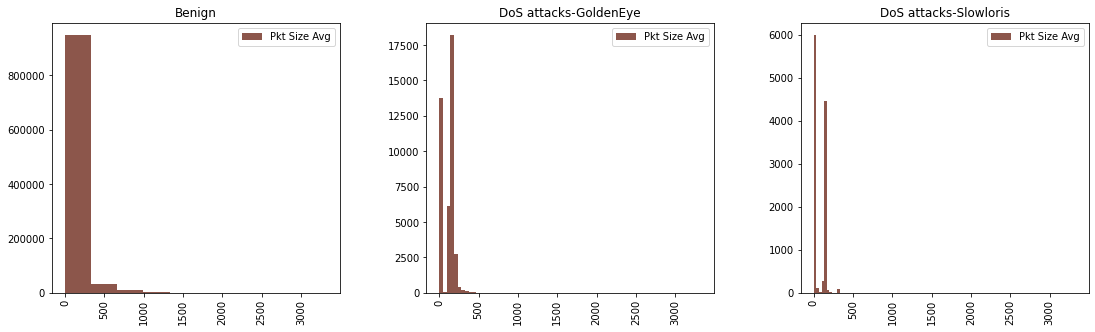

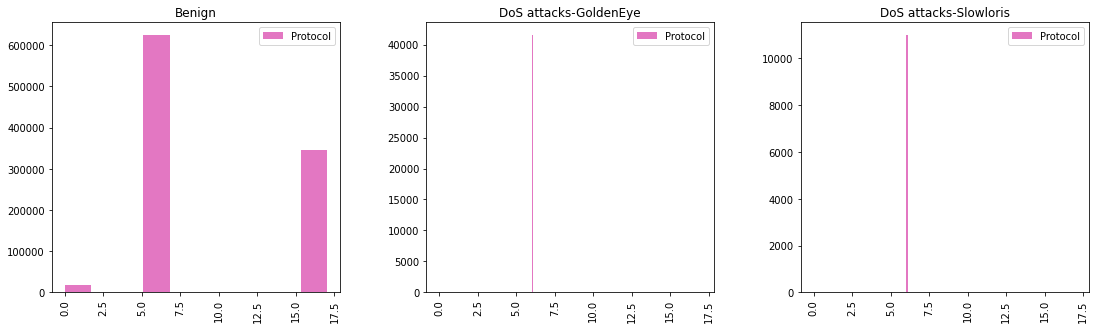

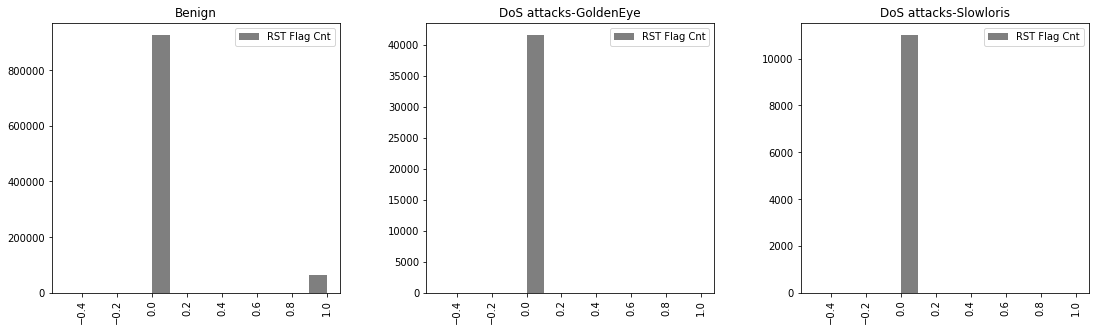

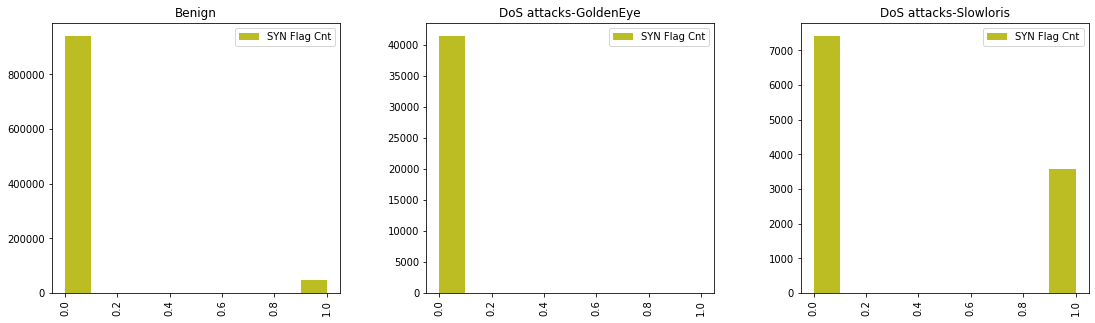

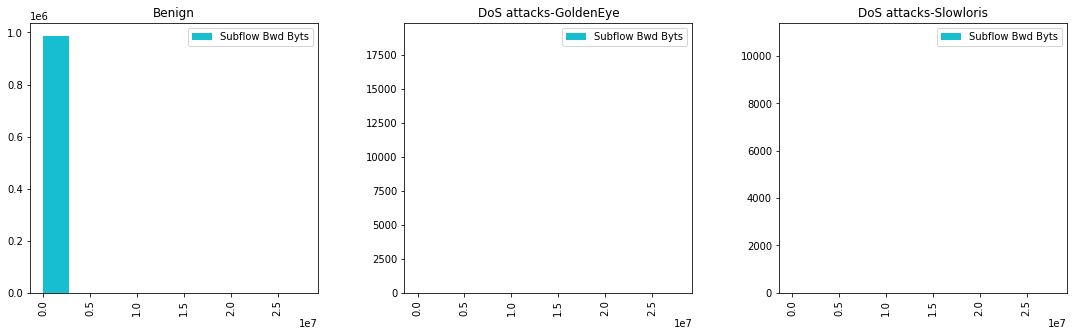

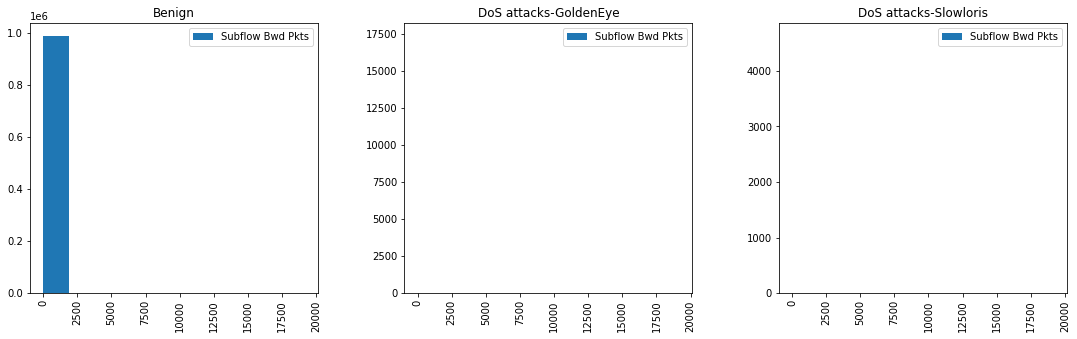

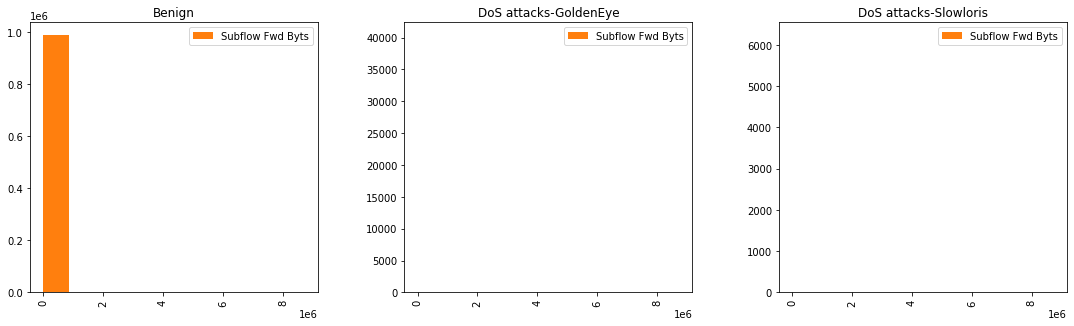

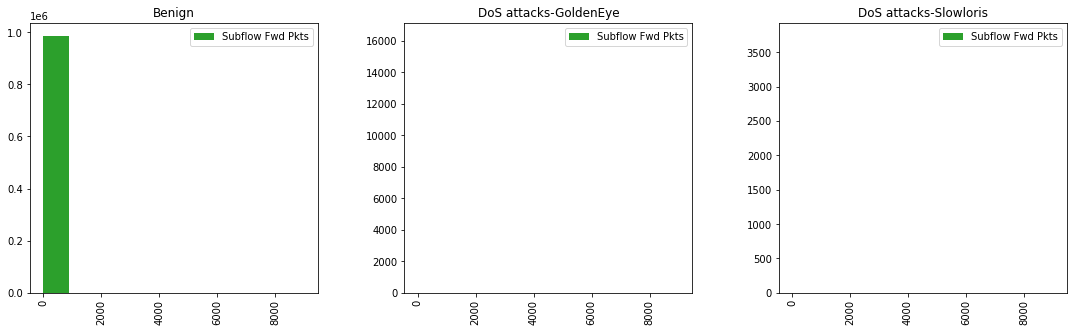

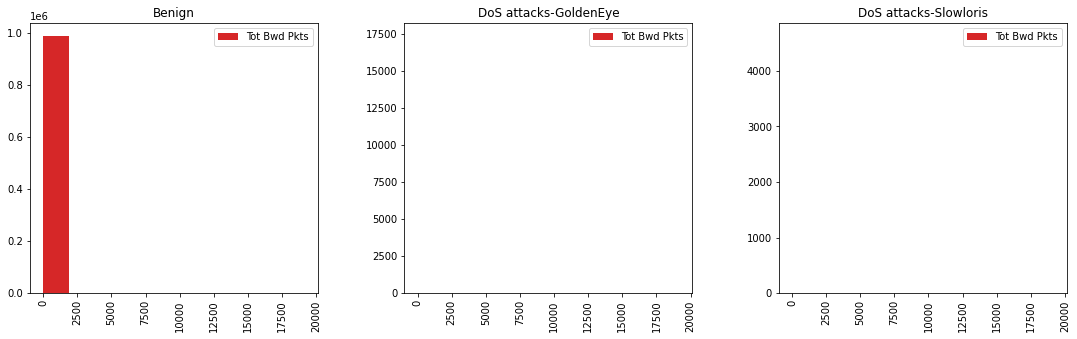

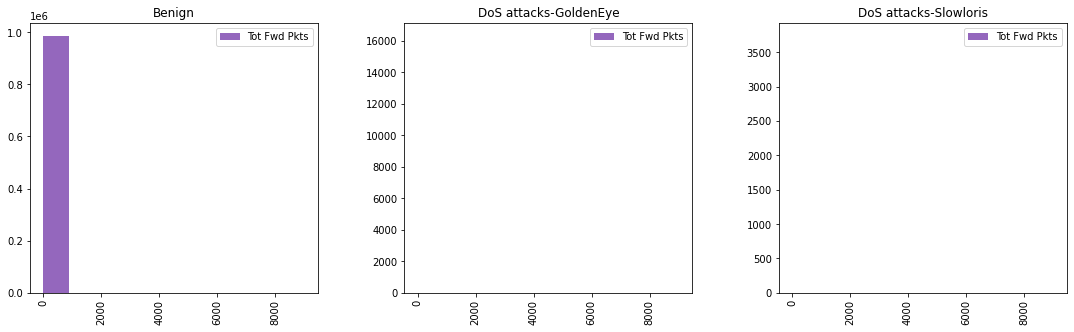

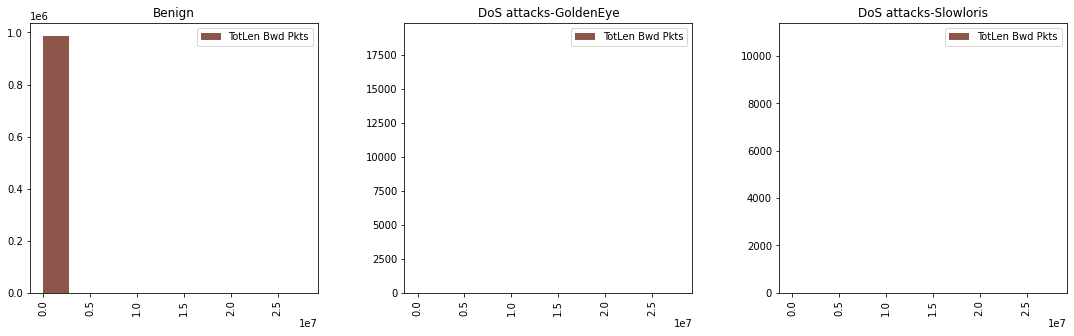

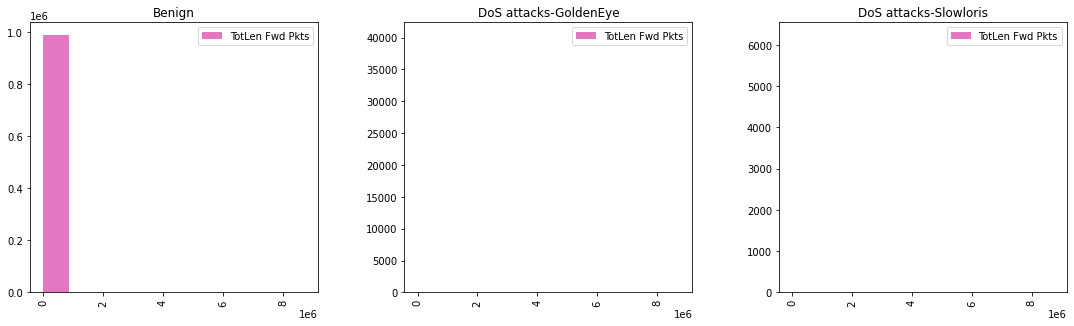

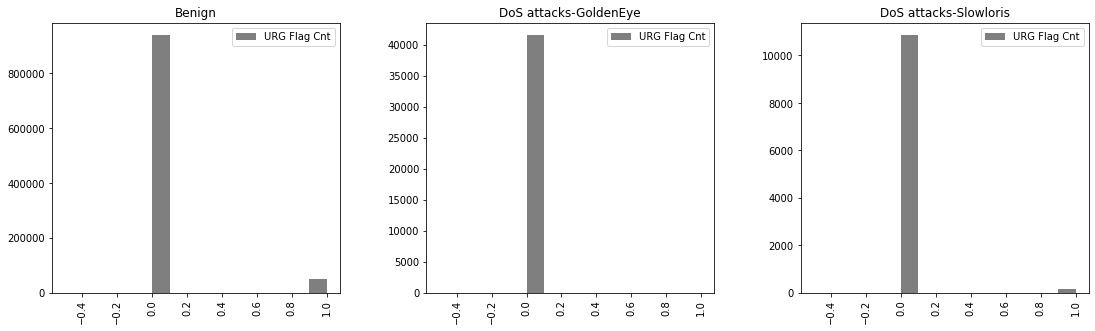

In [22]:
skip_columns = ['Timestamp','Label']

for i,c in enumerate(traffic_df.columns.difference(skip_columns)):
    traffic_df.hist(column=c, by='Label',figsize=(18,5), layout=(1,3), legend=True, color=f'C{i}',sharex=True)

## Timestamp histogram

For the sake of completion we will look at the time histogram. In cybersecurity applications such as this one, the use of timestamp is not advisable, as the attacker can fool the model by changing the time of attack. Timing on the other hand can be used to detect sequences of activities that indicate a certain type of suspecious traffic.

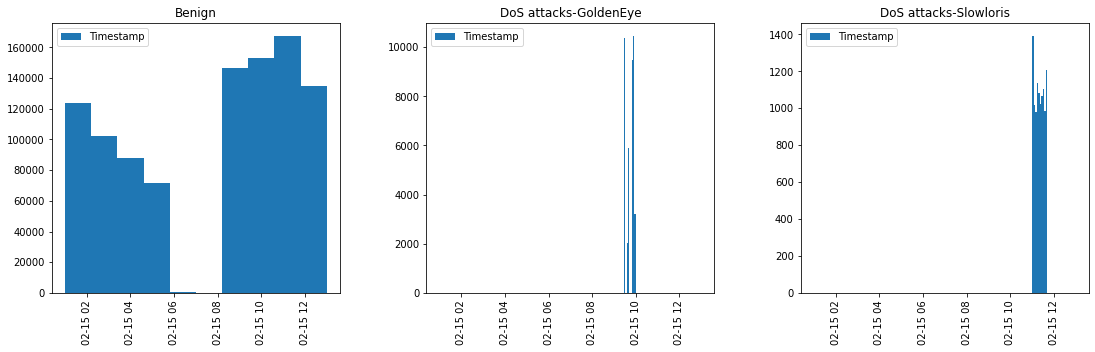

In [23]:
ax = traffic_df.hist(column='Timestamp', by='Label',figsize=(18,5), layout=(1,3), legend=True,bins=10,sharex=True)

### Delete timestamp from the dataset

In [24]:
traffic_df = traffic_df.drop('Timestamp', axis=1)
traffic_df

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,0,112641158,3,0,0,0,0,0,0.000000,...,0,0.0,0.000000,0,0,56320579.0,7.042784e+02,56321077,56320081,Benign
1,22,6,37366762,14,12,2168,2993,712,0,154.857143,...,32,1024353.0,649038.754495,1601183,321569,11431221.0,3.644991e+06,15617415,8960247,Benign
2,47514,6,543,2,0,64,0,64,0,32.000000,...,32,0.0,0.000000,0,0,0.0,0.000000e+00,0,0,Benign
3,0,0,112640703,3,0,0,0,0,0,0.000000,...,0,0.0,0.000000,0,0,56320351.5,3.669884e+02,56320611,56320092,Benign
4,0,0,112640874,3,0,0,0,0,0,0.000000,...,0,0.0,0.000000,0,0,56320437.0,7.198347e+02,56320946,56319928,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,50111,6,22,3,0,31,0,31,0,10.333333,...,20,0.0,0.000000,0,0,0.0,0.000000e+00,0,0,Benign
1048571,443,6,54682783,5,1,123,46,46,0,24.600000,...,20,158783.0,0.000000,158783,158783,54523813.0,0.000000e+00,54523813,54523813,Benign
1048572,443,6,53682093,5,1,123,46,46,0,24.600000,...,20,259719.0,0.000000,259719,259719,53421756.0,0.000000e+00,53421756,53421756,Benign
1048573,443,6,54683364,5,1,123,46,46,0,24.600000,...,20,158870.0,0.000000,158870,158870,54523593.0,0.000000e+00,54523593,54523593,Benign


# Train test split
We will use uniform random sampling of rows from the dataset, to create our dataset to insure that we have the same ratio of labels in the in the training set as in the origianl dataset. We will keep an eye on the label ratios in the origianl dataset and compare the ratios in the resultant training and test set.

In [25]:
traffic_df['Label'].value_counts(normalize = True)

Benign                   0.949548
DoS attacks-GoldenEye    0.039891
DoS attacks-Slowloris    0.010562
Name: Label, dtype: float64

We have almost the same ratios in the training set.

In [26]:
#Randomly sample dataset
test_ratio = 0.25
train_df = traffic_df.sample(frac=1-test_ratio, random_state = random_state)
train_df['Label'].value_counts(normalize = True)

Benign                   0.949496
DoS attacks-GoldenEye    0.040001
DoS attacks-Slowloris    0.010503
Name: Label, dtype: float64

In [27]:
train_df

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
834338,53,17,445,1,1,36,52,36,36,36.0,...,8,0.0,0.0,0,0,0.0,0.0,0,0,Benign
847337,52265,6,31,1,1,0,0,0,0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
68132,53,17,122284,2,2,96,180,48,48,48.0,...,8,0.0,0.0,0,0,0.0,0.0,0,0,Benign
524836,53,17,311,1,1,38,134,38,38,38.0,...,8,0.0,0.0,0,0,0.0,0.0,0,0,Benign
965362,445,6,508701,5,4,286,170,103,0,57.2,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177822,53,17,1468,1,1,37,113,37,37,37.0,...,8,0.0,0.0,0,0,0.0,0.0,0,0,Benign
5517,80,6,5004174,4,4,434,972,434,0,108.5,...,32,0.0,0.0,0,0,0.0,0.0,0,0,DoS attacks-GoldenEye
875495,3389,6,2330760,8,7,1148,1581,677,0,143.5,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
1018824,80,6,246075,2,0,0,0,0,0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign


We, also, have similar ratios in the test set.

In [28]:
test_df = traffic_df.drop(train_df.index)
test_df['Label'].value_counts(normalize = True)

Benign                   0.949703
DoS attacks-GoldenEye    0.039560
DoS attacks-Slowloris    0.010737
Name: Label, dtype: float64

In [29]:
test_df

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
9,22,6,25524814,17,12,1280,2273,712,0,75.294118,...,32,2726234.0,0.0,2726234,2726234,17163940.0,0.000000,17163940,17163940,Benign
17,0,0,112641174,3,0,0,0,0,0,0.000000,...,0,0.0,0.0,0,0,56320587.0,50.911688,56320623,56320551,Benign
18,0,0,112641282,3,0,0,0,0,0,0.000000,...,0,0.0,0.0,0,0,56320641.0,2.828427,56320643,56320639,Benign
19,0,0,112641497,3,0,0,0,0,0,0.000000,...,0,0.0,0.0,0,0,56320748.5,91.216775,56320813,56320684,Benign
25,0,0,112640384,3,0,0,0,0,0,0.000000,...,0,0.0,0.0,0,0,56320192.0,98.994949,56320262,56320122,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048555,0,0,112638659,3,0,0,0,0,0,0.000000,...,0,0.0,0.0,0,0,56319329.5,12.020815,56319338,56319321,Benign
1048556,445,6,169991,3,1,0,0,0,0,0.000000,...,20,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
1048558,443,6,289,3,0,77,0,46,0,25.666667,...,20,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
1048560,80,6,193157,3,4,148,242,148,0,49.333333,...,20,0.0,0.0,0,0,0.0,0.000000,0,0,Benign


# Preprocessing (Round 2)

## Handling high cardinality categorical features:

'Dst Port' can take any value from more than 21,000 categories. This columns which holds the protocol number cannot be one-hot encoded, as this will add around 21,000 new columns to the dataset. To minimize the number of categories we will bin the least common categories together and leave the top ones. We will bin the training set rather than the original dataset, because binning is a statistical operation in disguise as it can leak statistical information about the whole dataset if performed using the whole data.

In [30]:
dst_port = 'Dst Port'
traffic_df[[dst_port]].groupby([dst_port]).size().sort_values(ascending=False).shape[0]

21723

### Binning estimator API class
We will remain close to the API design guidelines of scikit-learn. While not strictly needed here, it is a good practice to keep things open to integration and future expansion. In this class, the top categories will retain their names while the rest will go under 'other'

In [31]:
class BinColumn(BaseEstimator, TransformerMixin):
    def __init__(self,column_name,target_bins=5):
        self.column_name = column_name
        self.bins = target_bins-1
        
    def fit(self,X,y=None):
        bins_se = X[[self.column_name]].groupby([self.column_name]).size().sort_values(ascending=False)
        self.top_bins_names = bins_se[:self.bins]
        return self
    
    def transform(self,X):
        lower_counts_df = X[~np.isin(X[self.column_name],self.top_bins_names.index)]
        lower_counts_df = lower_counts_df.copy()
        lower_counts_df.loc[:,(self.column_name,)] = 'other'
        top_counts_df = X[np.isin(X[self.column_name],self.top_bins_names.index)]
        return pd.concat([lower_counts_df, top_counts_df])
        

We will use 5 bins for this excercise. However, it's always adviable to experiment with several values. Below is each bin and its count in the Dst Port column.

In [32]:
#Fit and transform the training set
bins_num = 5
binner = BinColumn(dst_port,bins_num)
binner.fit(train_df) #Get bins using the training set 
train_df = binner.transform(train_df)#.drop('Label',axis = 1)).join(train_df[['Label']])
train_df[[dst_port]].groupby([dst_port]).size()

Dst Port
53       249821
80       179303
443      116721
3389      56294
other    178272
dtype: int64

In [33]:
train_df

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
847337,other,6,31,1,1,0,0,0,0,0.0,...,20,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
965362,other,6,508701,5,4,286,170,103,0,57.2,...,20,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
338630,other,6,477853,2,0,0,0,0,0,0.0,...,20,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
868458,other,0,112676676,3,0,0,0,0,0,0.0,...,0,0.0,0.0,0,0,56338338.0,677.408296,56338817,56337859,Benign
247924,other,6,33,2,0,0,0,0,0,0.0,...,20,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177822,53,17,1468,1,1,37,113,37,37,37.0,...,8,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
5517,80,6,5004174,4,4,434,972,434,0,108.5,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,DoS attacks-GoldenEye
875495,3389,6,2330760,8,7,1148,1581,677,0,143.5,...,20,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
1018824,80,6,246075,2,0,0,0,0,0,0.0,...,20,0.0,0.0,0,0,0.0,0.000000,0,0,Benign


Transform the test set

In [34]:
#Transform the test set
test_df = binner.transform(test_df)
test_df

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
9,other,6,25524814,17,12,1280,2273,712,0,75.294118,...,32,2726234.0,0.000000,2726234,2726234,1.716394e+07,0.000000,17163940,17163940,Benign
17,other,0,112641174,3,0,0,0,0,0,0.000000,...,0,0.0,0.000000,0,0,5.632059e+07,50.911688,56320623,56320551,Benign
18,other,0,112641282,3,0,0,0,0,0,0.000000,...,0,0.0,0.000000,0,0,5.632064e+07,2.828427,56320643,56320639,Benign
19,other,0,112641497,3,0,0,0,0,0,0.000000,...,0,0.0,0.000000,0,0,5.632075e+07,91.216775,56320813,56320684,Benign
25,other,0,112640384,3,0,0,0,0,0,0.000000,...,0,0.0,0.000000,0,0,5.632019e+07,98.994949,56320262,56320122,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048549,80,6,34515916,5,4,4,0,1,0,0.800000,...,20,11251.0,24.758837,11279,11232,1.008383e+07,4281.000623,10088652,10080475,Benign
1048553,443,6,219,3,0,77,0,46,0,25.666667,...,20,0.0,0.000000,0,0,0.000000e+00,0.000000,0,0,Benign
1048558,443,6,289,3,0,77,0,46,0,25.666667,...,20,0.0,0.000000,0,0,0.000000e+00,0.000000,0,0,Benign
1048560,80,6,193157,3,4,148,242,148,0,49.333333,...,20,0.0,0.000000,0,0,0.000000e+00,0.000000,0,0,Benign


## One-hot encoding
#### We will encode all the categorical columns (Flags etc.) -excluding labels- into one-hot features, 'Dst Port' will be encoded as well.

In [35]:
#Check columns with small number of values
column_unique_counts = traffic_df.nunique().sort_values()
column_unique_counts.head(50)

Fwd PSH Flags             2
FIN Flag Cnt              2
SYN Flag Cnt              2
RST Flag Cnt              2
PSH Flag Cnt              2
ACK Flag Cnt              2
URG Flag Cnt              2
ECE Flag Cnt              2
Label                     3
Protocol                  3
Fwd Seg Size Min         11
Down/Up Ratio            48
Pkt Len Min              92
Fwd Act Data Pkts       138
Fwd Pkt Len Min         142
Bwd Pkt Len Min         286
Subflow Fwd Pkts        694
Tot Fwd Pkts            694
Bwd Pkt Len Max        1172
Tot Bwd Pkts           1189
Subflow Bwd Pkts       1189
Pkt Len Max            1352
Fwd Header Len         1364
Fwd Pkt Len Max        1450
Bwd Header Len         2329
Init Fwd Win Byts      4445
Init Bwd Win Byts      5122
TotLen Fwd Pkts        7717
Subflow Fwd Byts       7717
Dst Port              21723
Subflow Bwd Byts      22673
TotLen Bwd Pkts       22673
Fwd Seg Size Avg      25680
Fwd Pkt Len Mean      25680
Bwd Seg Size Avg      38048
Bwd Pkt Len Mean    

In [36]:
# Get columns with 5 or less unique values
column_unique_counts = train_df.nunique()
categorical_columns = traffic_df[column_unique_counts.index[((column_unique_counts >= 1) & (column_unique_counts <= 5)) ]].columns
categorical_columns

Index(['Dst Port', 'Protocol', 'Fwd PSH Flags', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'ECE Flag Cnt', 'Label'],
      dtype='object')

In [37]:
traffic_df[categorical_columns]

,Dst Port,Protocol,Fwd PSH Flags,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,ECE Flag Cnt,Label
0,0,0,0,0,0,0,0,0,0,0,Benign
1,22,6,0,0,0,0,1,0,0,0,Benign
2,47514,6,1,0,1,0,0,1,0,0,Benign
3,0,0,0,0,0,0,0,0,0,0,Benign
4,0,0,0,0,0,0,0,0,0,0,Benign
...,...,...,...,...,...,...,...,...,...,...,...
1048570,50111,6,0,0,0,0,0,1,0,0,Benign
1048571,443,6,1,0,1,0,0,1,0,0,Benign
1048572,443,6,1,0,1,0,0,1,0,0,Benign
1048573,443,6,1,0,1,0,0,1,0,0,Benign


### One-hot estimator API class
#### A class that utilizes scikit-learn class library to perform one-hot fit and transform on a dataset, after "detecting" categorical features.

In [38]:
class PaucalOneHotter(BaseEstimator, TransformerMixin):
    def __init__(self,max_number_of_categories,drop_column):
        self.max_number_of_categories = max_number_of_categories
        self.drop_column = drop_column
        
    def fit(self,X,y=None):
        column_unique_counts = X.nunique()
        categorical_columns = X[column_unique_counts.index[((column_unique_counts >= 2) & (column_unique_counts <= self.max_number_of_categories)) ]].columns
        self.categorical_columns = categorical_columns.difference([self.drop_column])
        return self
    
    def transform(self,X):
        X[self.categorical_columns] = X[self.categorical_columns].astype('str') #Convert all categorical columns to strings
        train_dummies_df = pd.get_dummies(X[self.categorical_columns])
        X = X.drop(self.categorical_columns,axis=1).join(train_dummies_df)
        return X
        
        


p_one_hotter = PaucalOneHotter(bins_num,'Label') #Use the number of bins as a paucity threshold
p_one_hotter.fit(train_df)
train_df = p_one_hotter.transform(train_df)
train_df

,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,...,PSH Flag Cnt_1,Protocol_0,Protocol_17,Protocol_6,RST Flag Cnt_0,RST Flag Cnt_1,SYN Flag Cnt_0,SYN Flag Cnt_1,URG Flag Cnt_0,URG Flag Cnt_1
847337,31,1,1,0,0,0,0,0.0,0.000000,0,...,0,0,0,1,1,0,1,0,0,1
965362,508701,5,4,286,170,103,0,57.2,52.485236,131,...,1,0,0,1,1,0,1,0,1,0
338630,477853,2,0,0,0,0,0,0.0,0.000000,0,...,0,0,0,1,1,0,1,0,1,0
868458,112676676,3,0,0,0,0,0,0.0,0.000000,0,...,0,1,0,0,1,0,1,0,1,0
247924,33,2,0,0,0,0,0,0.0,0.000000,0,...,0,0,0,1,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177822,1468,1,1,37,113,37,37,37.0,0.000000,113,...,0,0,1,0,1,0,1,0,1,0
5517,5004174,4,4,434,972,434,0,108.5,217.000000,972,...,1,0,0,1,1,0,1,0,1,0
875495,2330760,8,7,1148,1581,677,0,143.5,228.129662,1173,...,1,0,0,1,1,0,1,0,1,0
1018824,246075,2,0,0,0,0,0,0.0,0.000000,0,...,0,0,0,1,1,0,1,0,1,0


In [39]:
test_df = p_one_hotter.transform(test_df)
test_df

,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,...,PSH Flag Cnt_1,Protocol_0,Protocol_17,Protocol_6,RST Flag Cnt_0,RST Flag Cnt_1,SYN Flag Cnt_0,SYN Flag Cnt_1,URG Flag Cnt_0,URG Flag Cnt_1
9,25524814,17,12,1280,2273,712,0,75.294118,177.449910,976,...,1,0,0,1,1,0,1,0,1,0
17,112641174,3,0,0,0,0,0,0.000000,0.000000,0,...,0,1,0,0,1,0,1,0,1,0
18,112641282,3,0,0,0,0,0,0.000000,0.000000,0,...,0,1,0,0,1,0,1,0,1,0
19,112641497,3,0,0,0,0,0,0.000000,0.000000,0,...,0,1,0,0,1,0,1,0,1,0
25,112640384,3,0,0,0,0,0,0.000000,0.000000,0,...,0,1,0,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048549,34515916,5,4,4,0,1,0,0.800000,0.447214,0,...,0,0,0,1,1,0,1,0,1,0
1048553,219,3,0,77,0,46,0,25.666667,23.459184,0,...,0,0,0,1,1,0,0,1,1,0
1048558,289,3,0,77,0,46,0,25.666667,23.459184,0,...,0,0,0,1,1,0,0,1,1,0
1048560,193157,3,4,148,242,148,0,49.333333,85.447840,242,...,1,0,0,1,0,1,1,0,1,0


#### Now our dataset is ready for training except for two things balancing and normalization, and we will see below that these steps need to take place in this order.

# Undersampling of majority classes

#### We will start by the computationally cheapest option, undesampling by dropping rows in the majority class and the second majority class so that they match the minority class. This will leave us with about 24,500 records in three classes, which is not unreasonable a number of datapoints.

Get class correction factors.

In [40]:
#Class correction ratios
counts = train_df['Label'].value_counts().sort_values()
print(counts)
class_ratios = [counts[0]/counts[i] for i in range(len(counts))]
class_ratios

DoS attacks-Slowloris      8197
DoS attacks-GoldenEye     31217
Benign                   740997
Name: Label, dtype: int64


[1.0, 0.2625812858378448, 0.011062123058527903]

#### Undersample each class according to its ratio

In [41]:
temp_df = pd.DataFrame()
for i,lbl in enumerate(counts.index):
    print(i,lbl)
    temp_df = pd.concat([temp_df,train_df[train_df['Label'] == lbl].sample(frac=class_ratios[i])])
temp_df

0 DoS attacks-Slowloris
1 DoS attacks-GoldenEye
2 Benign


,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,...,PSH Flag Cnt_1,Protocol_0,Protocol_17,Protocol_6,RST Flag Cnt_0,RST Flag Cnt_1,SYN Flag Cnt_0,SYN Flag Cnt_1,URG Flag Cnt_0,URG Flag Cnt_1
33221,107069815,15,3,2530,0,230,0,168.666667,105.279673,0,...,1,0,0,1,1,0,1,0,1,0
29713,103076066,2,2,16,0,8,8,8.000000,0.000000,0,...,0,0,0,1,1,0,0,1,1,0
35111,107265276,15,3,2530,0,230,0,168.666667,105.279673,0,...,1,0,0,1,1,0,1,0,1,0
49180,3078546,3,0,0,0,0,0,0.000000,0.000000,0,...,1,0,0,1,1,0,1,0,1,0
43896,107566142,15,3,2380,0,238,0,158.666667,114.994824,0,...,1,0,0,1,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481413,912,1,1,35,51,35,35,35.000000,0.000000,51,...,0,0,1,0,1,0,1,0,1,0
754398,112635056,3,0,0,0,0,0,0.000000,0.000000,0,...,0,1,0,0,1,0,1,0,1,0
917094,1022,1,1,40,139,40,40,40.000000,0.000000,139,...,0,0,1,0,1,0,1,0,1,0
930378,49868,2,2,76,108,38,38,38.000000,0.000000,54,...,0,0,1,0,1,0,1,0,1,0


#### Check if class counts match in the undersampled dataset

In [42]:
temp_df['Label'].value_counts()

DoS attacks-Slowloris    8197
DoS attacks-GoldenEye    8197
Benign                   8197
Name: Label, dtype: int64

#### There is no need to undersample the test set

## Normalization
#### We will normalize the columns of the data set using the standard normal distribution. We have waited for normalization until now because the standard normal distribution is takes the average and standard diviation of the column and use them to calcualte a new value for each cell of the column based on the original value. In highly imabalanced datasets the majority classes average and standard diviation would contribute the most, which introduces noise in the minority classes values.

#### First we need to move one-hot columns out of the way

In [43]:
#Omit onehot columns for scaling; these are the columns that have exactly two unique values

columns_unique_counts = train_df.nunique()
one_hot_columns = columns_unique_counts[columns_unique_counts==2].index
temp_df[temp_df.columns.difference(one_hot_columns)]

,Active Max,Active Mean,Active Min,Active Std,Bwd Header Len,Bwd IAT Max,Bwd IAT Mean,Bwd IAT Min,Bwd IAT Std,Bwd IAT Tot,...,Pkt Len Var,Pkt Size Avg,Subflow Bwd Byts,Subflow Bwd Pkts,Subflow Fwd Byts,Subflow Fwd Pkts,Tot Bwd Pkts,Tot Fwd Pkts,TotLen Bwd Pkts,TotLen Fwd Pkts
33221,7742799,6155611.0,4568423,2.244623e+06,100,75047150,5.302345e+07,30999755,3.114621e+07,106046905,...,13611.695906,140.555556,0,3,2530,15,3,15,0,2530
29713,2,2.0,2,0.000000e+00,64,103076064,1.030761e+08,103076064,0.000000e+00,103076064,...,19.200000,6.000000,0,2,16,2,2,2,0,16
35111,7710038,6173631.5,4637225,2.172807e+06,100,75241259,5.311883e+07,30996396,3.128584e+07,106237655,...,13611.695906,140.555556,0,3,2530,15,3,15,0,2530
49180,0,0.0,0,0.000000e+00,0,0,0.000000e+00,0,0.000000e+00,0,...,0.000000,0.000000,0,0,0,3,0,3,0,0
43896,7748334,6041788.0,4335242,2.413420e+06,100,75543501,5.327083e+07,30998160,3.149831e+07,106541661,...,14701.871345,132.222222,0,3,2380,15,3,15,0,2380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481413,0,0.0,0,0.000000e+00,8,0,0.000000e+00,0,0.000000e+00,0,...,85.333333,60.500000,51,1,35,1,1,1,51,35
754398,0,0.0,0,0.000000e+00,0,0,0.000000e+00,0,0.000000e+00,0,...,0.000000,0.000000,0,0,0,3,0,3,0,0
917094,0,0.0,0,0.000000e+00,8,0,0.000000e+00,0,0.000000e+00,0,...,3267.000000,109.500000,139,1,40,1,1,1,139,40
930378,0,0.0,0,0.000000e+00,16,49227,4.922700e+04,49227,0.000000e+00,49227,...,76.800000,55.500000,108,2,76,2,2,2,108,76


#### Fit and transform the training set

In [44]:
columns_to_scale = temp_df.columns.difference(one_hot_columns.union(['Label']))
columns_to_scale

Index(['Active Max', 'Active Mean', 'Active Min', 'Active Std',
       'Bwd Header Len', 'Bwd IAT Max', 'Bwd IAT Mean', 'Bwd IAT Min',
       'Bwd IAT Std', 'Bwd IAT Tot', 'Bwd Pkt Len Max', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Min', 'Bwd Pkt Len Std', 'Bwd Pkts/s', 'Bwd Seg Size Avg',
       'Down/Up Ratio', 'Flow Byts/s', 'Flow Duration', 'Flow IAT Max',
       'Flow IAT Mean', 'Flow IAT Min', 'Flow IAT Std', 'Flow Pkts/s',
       'Fwd Act Data Pkts', 'Fwd Header Len', 'Fwd IAT Max', 'Fwd IAT Mean',
       'Fwd IAT Min', 'Fwd IAT Std', 'Fwd IAT Tot', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Mean', 'Fwd Pkt Len Min', 'Fwd Pkt Len Std', 'Fwd Pkts/s',
       'Fwd Seg Size Avg', 'Fwd Seg Size Min', 'Idle Max', 'Idle Mean',
       'Idle Min', 'Idle Std', 'Init Bwd Win Byts', 'Init Fwd Win Byts',
       'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Min', 'Pkt Len Std',
       'Pkt Len Var', 'Pkt Size Avg', 'Subflow Bwd Byts', 'Subflow Bwd Pkts',
       'Subflow Fwd Byts', 'Subflow Fwd Pkts', 'T

In [45]:
sc = StandardScaler()
temp_df[columns_to_scale] = sc.fit_transform(temp_df[columns_to_scale])

In [46]:
temp_df

,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,...,PSH Flag Cnt_1,Protocol_0,Protocol_17,Protocol_6,RST Flag Cnt_0,RST Flag Cnt_1,SYN Flag Cnt_0,SYN Flag Cnt_1,URG Flag Cnt_0,URG Flag Cnt_1
33221,1.651032,0.482327,-0.016487,1.861826,-0.033063,0.248050,-0.324989,1.523427,0.303663,-0.669273,...,1,0,0,1,1,0,1,0,1,0
29713,1.562510,-0.182817,-0.039889,-0.554899,-0.033063,-0.816540,0.082936,-0.830369,-0.829788,-0.669273,...,0,0,0,1,1,0,0,1,1,0
35111,1.655364,0.482327,-0.016487,1.861826,-0.033063,0.248050,-0.324989,1.523427,0.303663,-0.669273,...,1,0,0,1,1,0,1,0,1,0
49180,-0.653959,-0.131652,-0.086693,-0.570280,-0.033063,-0.854904,-0.324989,-0.947570,-0.829788,-0.669273,...,1,0,0,1,1,0,1,0,1,0
43896,1.662033,0.482327,-0.016487,1.717630,-0.033063,0.286413,-0.324989,1.376925,0.408257,-0.669273,...,1,0,0,1,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481413,-0.722175,-0.233982,-0.063291,-0.536634,-0.032222,-0.687063,1.459682,-0.434814,-0.829788,-0.554975,...,0,0,1,0,1,0,1,0,1,0
754398,1.774387,-0.131652,-0.086693,-0.570280,-0.033063,-0.854904,-0.324989,-0.947570,-0.829788,-0.669273,...,0,1,0,0,1,0,1,0,1,0
917094,-0.722173,-0.233982,-0.063291,-0.531828,-0.030771,-0.663086,1.714635,-0.361563,-0.829788,-0.357753,...,0,0,1,0,1,0,1,0,1,0
930378,-0.721090,-0.182817,-0.039889,-0.497221,-0.031282,-0.672677,1.612654,-0.390863,-0.829788,-0.548251,...,0,0,1,0,1,0,1,0,1,0


Transfrom (scale) the test set.

In [47]:
test_df[columns_to_scale] = sc.transform(test_df[columns_to_scale] )

In [48]:
test_df

,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,...,PSH Flag Cnt_1,Protocol_0,Protocol_17,Protocol_6,RST Flag Cnt_0,RST Flag Cnt_1,SYN Flag Cnt_0,SYN Flag Cnt_1,URG Flag Cnt_0,URG Flag Cnt_1
9,-0.156432,0.584656,0.194130,0.660192,0.004420,2.559457,-0.324989,0.155502,1.080655,1.518090,...,1,0,0,1,1,0,1,0,1,0
17,1.774522,-0.131652,-0.086693,-0.570280,-0.033063,-0.854904,-0.324989,-0.947570,-0.829788,-0.669273,...,0,1,0,0,1,0,1,0,1,0
18,1.774525,-0.131652,-0.086693,-0.570280,-0.033063,-0.854904,-0.324989,-0.947570,-0.829788,-0.669273,...,0,1,0,0,1,0,1,0,1,0
19,1.774530,-0.131652,-0.086693,-0.570280,-0.033063,-0.854904,-0.324989,-0.947570,-0.829788,-0.669273,...,0,1,0,0,1,0,1,0,1,0
25,1.774505,-0.131652,-0.086693,-0.570280,-0.033063,-0.854904,-0.324989,-0.947570,-0.829788,-0.669273,...,0,1,0,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048549,0.042858,-0.029322,0.006915,-0.566435,-0.033063,-0.850109,-0.324989,-0.935850,-0.824973,-0.669273,...,0,0,0,1,1,0,1,0,1,0
1048553,-0.722190,-0.131652,-0.086693,-0.496259,-0.033063,-0.634313,-0.324989,-0.571549,-0.577224,-0.669273,...,0,0,0,1,1,0,0,1,1,0
1048558,-0.722189,-0.131652,-0.086693,-0.496259,-0.033063,-0.634313,-0.324989,-0.571549,-0.577224,-0.669273,...,0,0,0,1,1,0,0,1,1,0
1048560,-0.717914,-0.131652,0.006915,-0.428007,-0.029072,-0.145177,-0.324989,-0.224828,0.090152,-0.126915,...,1,0,0,1,0,1,1,0,1,0


#### The dataset is ready for training classifiers

# Classification

## Random Forest Classifier

### Random Forest Classifier with All Features

In [49]:
# Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=50, random_state = random_state)
rf_clf.fit(temp_df.drop('Label', axis=1),temp_df['Label'])


RandomForestClassifier(n_estimators=50, random_state=5)

### Accuracy:

In [50]:
rf_clf.score(test_df.drop('Label',axis=1),test_df['Label'])

0.9999423380757063

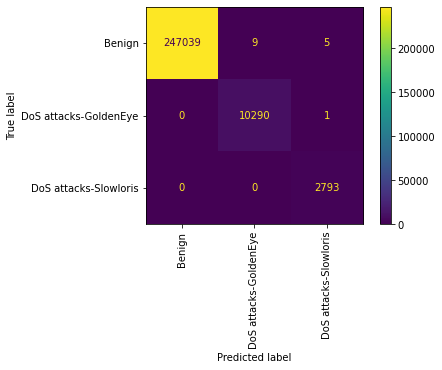

In [51]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(rf_clf,test_df.drop('Label',axis=1),test_df['Label'],values_format = '', xticks_rotation = 'vertical')
plt.grid(False)

### Random Forest Classifier with numerical features only

In [52]:
# Random Forest Classifier
rf_clf_sc = RandomForestClassifier(n_estimators=50, random_state = random_state)
rf_clf_sc.fit(temp_df[columns_to_scale],temp_df['Label'])

RandomForestClassifier(n_estimators=50, random_state=5)

### Accuracy

In [53]:
rf_clf_sc.score(test_df[columns_to_scale],test_df['Label'])

0.9977358084393992

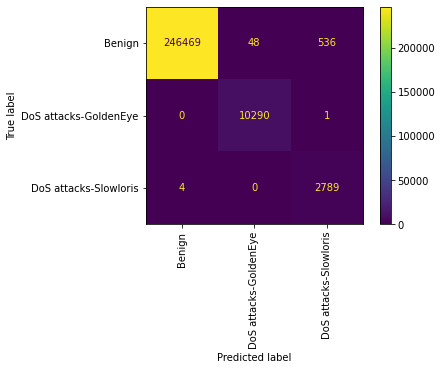

In [54]:
ConfusionMatrixDisplay.from_estimator(rf_clf_sc,test_df[columns_to_scale],test_df['Label'],values_format = '', xticks_rotation = 'vertical')
plt.grid(False)

## kNN Classifier

### kNN Classifier with all the features

In [55]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(temp_df.drop('Label', axis=1),temp_df['Label'])
knn_clf.score(test_df.drop('Label',axis=1),test_df['Label'])

0.9982047920903216

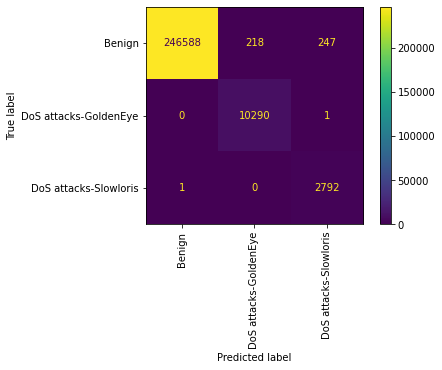

In [56]:
ConfusionMatrixDisplay.from_estimator(knn_clf,test_df.drop('Label',axis=1),test_df['Label'],values_format = '', xticks_rotation = 'vertical')
plt.grid(False)

In [57]:
from sklearn.svm import SVC

svc_clf = SVC()
svc_clf.fit(temp_df.drop('Label', axis=1),temp_df['Label'])


SVC()

### Accuracy

In [58]:
svc_clf.score(test_df.drop('Label',axis=1),test_df['Label'])

0.9998846761514125

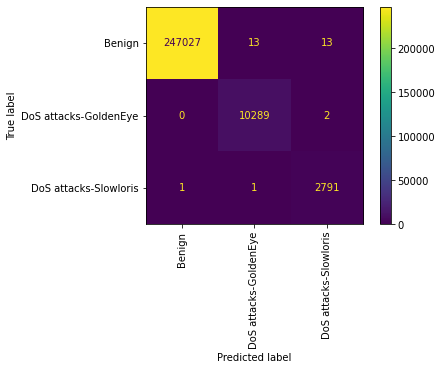

In [59]:
ConfusionMatrixDisplay.from_estimator(svc_clf,test_df.drop('Label',axis=1),test_df['Label'],values_format = '', xticks_rotation = 'vertical')
plt.grid(False)

# Percision, Recall, F1-score and ROCAUC
#### The macro average is the most indicative of the performance of our model in this case. The micro average, on the otherhand, produces high percentages in case the model favors the imbalanced class. Below is are percision, recall and F1-scores for the first Random Forest above.

In [60]:
from sklearn.metrics import classification_report
target_values = test_df['Label'].value_counts().sort_values(ascending = False).index

print("First random forest:\n",classification_report(test_df['Label'], rf_clf.predict(test_df.drop('Label',axis=1)), target_names=target_values,digits = 5))

First random forest:
                        precision    recall  f1-score   support

               Benign    1.00000   0.99994   0.99997    247053
DoS attacks-GoldenEye    0.99913   0.99990   0.99951     10291
DoS attacks-Slowloris    0.99786   1.00000   0.99893      2793

             accuracy                        0.99994    260137
            macro avg    0.99899   0.99995   0.99947    260137
         weighted avg    0.99994   0.99994   0.99994    260137



In [61]:
print("kNN:\n",classification_report(test_df['Label'], knn_clf.predict(test_df.drop('Label',axis=1)), target_names=target_values,digits = 5))

kNN:
                        precision    recall  f1-score   support

               Benign    1.00000   0.99812   0.99906    247053
DoS attacks-GoldenEye    0.97925   0.99990   0.98947     10291
DoS attacks-Slowloris    0.91842   0.99964   0.95731      2793

             accuracy                        0.99820    260137
            macro avg    0.96589   0.99922   0.98195    260137
         weighted avg    0.99830   0.99820   0.99823    260137



In [62]:
print("SVC:\n",classification_report(test_df['Label'], svc_clf.predict(test_df.drop('Label',axis=1)), target_names=target_values,digits = 5))

SVC:
                        precision    recall  f1-score   support

               Benign    1.00000   0.99989   0.99995    247053
DoS attacks-GoldenEye    0.99864   0.99981   0.99922     10291
DoS attacks-Slowloris    0.99465   0.99928   0.99696      2793

             accuracy                        0.99988    260137
            macro avg    0.99776   0.99966   0.99871    260137
         weighted avg    0.99989   0.99988   0.99988    260137



### ROC-AUC

#### ROC-AUC curves are normally defined for binary classification tasks. Below is a ROC-AUC curve that builds on the same idea for multi-class problems. Below is the ROC-AUC plot for first random forest.

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


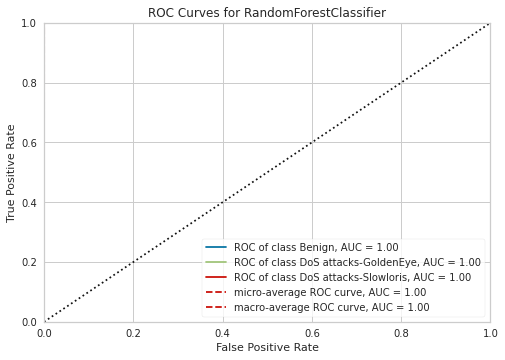

<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [63]:
from yellowbrick.classifier import ROCAUC
vis = ROCAUC(rf_clf, classes=target_values)
vis.fit(temp_df.drop('Label', axis=1),temp_df['Label'])  
vis.score(test_df.drop('Label',axis=1), test_df['Label'])
vis.show()

### Sanity check using a mediocre classifier

#### The ROC curve above has an almost ideal form it forms a right angle at the top-left corner -This is the reason it is hardly visible. Below is the ROC-AUC curve for a poor random forest classifier.

In [64]:
rf3_clf = RandomForestClassifier(n_estimators = 1,max_depth=2)
rf3_clf.fit(temp_df.drop('Label', axis=1),temp_df['Label'])

RandomForestClassifier(max_depth=2, n_estimators=1)

In [65]:
print(classification_report(test_df['Label'], rf3_clf.predict(test_df.drop('Label',axis=1)), target_names=target_values,digits = 5))

                       precision    recall  f1-score   support

               Benign    0.98389   0.97205   0.97794    247053
DoS attacks-GoldenEye    0.46947   0.65008   0.54521     10291
DoS attacks-Slowloris    0.99115   0.64125   0.77870      2793

             accuracy                        0.95577    260137
            macro avg    0.81484   0.75446   0.76728    260137
         weighted avg    0.96362   0.95577   0.95868    260137



/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


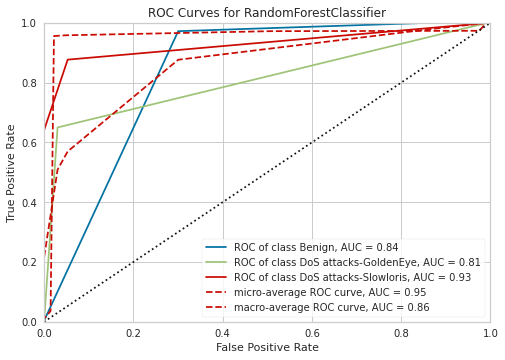

<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [66]:
visualizer = ROCAUC(rf3_clf, classes=target_values)
visualizer.fit(temp_df.drop('Label', axis=1),temp_df['Label'])  
visualizer.score(test_df.drop('Label',axis=1), test_df['Label'])
visualizer.show()

# Clustering
#### We will cluster the whole dataset, assuming unlabeled dataset. We will use kmeans for this clustering task, but other algorithms such as DBSCAN are worth exploring DBSCAN has the ability to exclude outliers. This is particularly desirable in the context of cybersecurity to detect novel kinds of threats. GMM is a much better choice for measuring how close a vector to the center (mean). Through a set of multivariate normal distributions it can be used to measure the similarity of a certain point to the mean by measuring the Mahalanobis distance between the two. This is the multivariate equivalent of how many standard deviations from the mean a univariate random variable is. This is why GMM is more statistically sound clustering method. Both algorithms are much more computationally expensive than kmeans, which will make it difficult to consider them in this notebook. 

## Bin 'Dst Port' Column

In [67]:
binner2 = BinColumn(dst_port,bins_num)
binner2.fit(traffic_df)
traffic_df = binner2.transform(traffic_df)
traffic_df[[dst_port]].groupby([dst_port]).size()

Dst Port
53       333090
80       239043
443      155745
3389      74961
other    237709
dtype: int64

## One-hot encode categorical data

In [68]:
p_one_hotter2 = PaucalOneHotter(bins_num,'Label')
p_one_hotter2.fit(traffic_df)
traffic_df = p_one_hotter2.transform(traffic_df)
traffic_df

,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,...,PSH Flag Cnt_1,Protocol_0,Protocol_17,Protocol_6,RST Flag Cnt_0,RST Flag Cnt_1,SYN Flag Cnt_0,SYN Flag Cnt_1,URG Flag Cnt_0,URG Flag Cnt_1
0,112641158,3,0,0,0,0,0,0.000000,0.000000,0,...,0,1,0,0,1,0,1,0,1,0
1,37366762,14,12,2168,2993,712,0,154.857143,254.855270,976,...,1,0,0,1,1,0,1,0,1,0
2,543,2,0,64,0,64,0,32.000000,45.254834,0,...,0,0,0,1,1,0,0,1,1,0
3,112640703,3,0,0,0,0,0,0.000000,0.000000,0,...,0,1,0,0,1,0,1,0,1,0
4,112640874,3,0,0,0,0,0,0.000000,0.000000,0,...,0,1,0,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048569,53668766,5,1,123,46,46,0,24.600000,23.276598,46,...,0,0,0,1,1,0,0,1,1,0
1048571,54682783,5,1,123,46,46,0,24.600000,23.276598,46,...,0,0,0,1,1,0,0,1,1,0
1048572,53682093,5,1,123,46,46,0,24.600000,23.276598,46,...,0,0,0,1,1,0,0,1,1,0
1048573,54683364,5,1,123,46,46,0,24.600000,23.276598,46,...,0,0,0,1,1,0,0,1,1,0


## Normalize and drop label

In [69]:
sc2 = StandardScaler()
traffic_df[columns_to_scale] = sc2.fit_transform(traffic_df[columns_to_scale])

In [70]:
traffic_df = traffic_df.drop('Label',axis=1) #Label need not be present in the clustering data

In [71]:
traffic_df

,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,...,PSH Flag Cnt_1,Protocol_0,Protocol_17,Protocol_6,RST Flag Cnt_0,RST Flag Cnt_1,SYN Flag Cnt_0,SYN Flag Cnt_1,URG Flag Cnt_0,URG Flag Cnt_1
0,2.935578,-0.063962,-0.065852,-0.015166,-0.035334,-0.548114,-0.589618,-0.742183,-0.558089,-0.672959,...,0,1,0,0,1,0,1,0,1,0
1,0.685871,0.260252,0.056300,0.059788,-0.014029,2.010984,-0.589618,1.811057,2.224321,1.299104,...,1,0,0,1,1,0,1,0,1,0
2,-0.430884,-0.093436,-0.065852,-0.012954,-0.035334,-0.318082,-0.589618,-0.214576,-0.064015,-0.672959,...,0,0,0,1,1,0,0,1,1,0
3,2.935564,-0.063962,-0.065852,-0.015166,-0.035334,-0.548114,-0.589618,-0.742183,-0.558089,-0.672959,...,0,1,0,0,1,0,1,0,1,0
4,2.935569,-0.063962,-0.065852,-0.015166,-0.035334,-0.548114,-0.589618,-0.742183,-0.558089,-0.672959,...,0,1,0,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048569,1.173085,-0.005014,-0.055673,-0.010914,-0.035006,-0.382779,-0.589618,-0.336585,-0.303965,-0.580014,...,0,0,0,1,1,0,0,1,1,0
1048571,1.203390,-0.005014,-0.055673,-0.010914,-0.035006,-0.382779,-0.589618,-0.336585,-0.303965,-0.580014,...,0,0,0,1,1,0,0,1,1,0
1048572,1.173483,-0.005014,-0.055673,-0.010914,-0.035006,-0.382779,-0.589618,-0.336585,-0.303965,-0.580014,...,0,0,0,1,1,0,0,1,1,0
1048573,1.203408,-0.005014,-0.055673,-0.010914,-0.035006,-0.382779,-0.589618,-0.336585,-0.303965,-0.580014,...,0,0,0,1,1,0,0,1,1,0


# Perform kmeans from 1 to 20 clusters

In [72]:
from sklearn.cluster import KMeans
km_models = {}
for i in range(1,21):
    print(f'Fitting {i}-cluster model ...')
    kmeans = KMeans(n_clusters=i, max_iter=1000, random_state = random_state)
    km_models[i] = kmeans.fit(traffic_df)
    inertia = km_models[i].inertia_
    print(f'  Inertia = {inertia}')


Fitting 1-cluster model ...
  Inertia = 63076334.214787275
Fitting 2-cluster model ...
  Inertia = 52048539.90298234
Fitting 3-cluster model ...
  Inertia = 46135509.0071799
Fitting 4-cluster model ...
  Inertia = 40533858.8879483
Fitting 5-cluster model ...
  Inertia = 36523351.38305659
Fitting 6-cluster model ...
  Inertia = 32100415.626502905
Fitting 7-cluster model ...
  Inertia = 28794483.70368598
Fitting 8-cluster model ...
  Inertia = 26422986.214034915
Fitting 9-cluster model ...
  Inertia = 24740295.701584436
Fitting 10-cluster model ...
  Inertia = 22705520.94920763
Fitting 11-cluster model ...
  Inertia = 22255174.397295233
Fitting 12-cluster model ...
  Inertia = 20542351.646566972
Fitting 13-cluster model ...
  Inertia = 19182311.315129295
Fitting 14-cluster model ...
  Inertia = 18553851.42947603
Fitting 15-cluster model ...
  Inertia = 17806559.0124255
Fitting 16-cluster model ...
  Inertia = 16838357.953566194
Fitting 17-cluster model ...
  Inertia = 15880912.606829157


## Elbow curve

#### A good candidate for the optimal number of cluster is 17 based on the elbow point at 17.

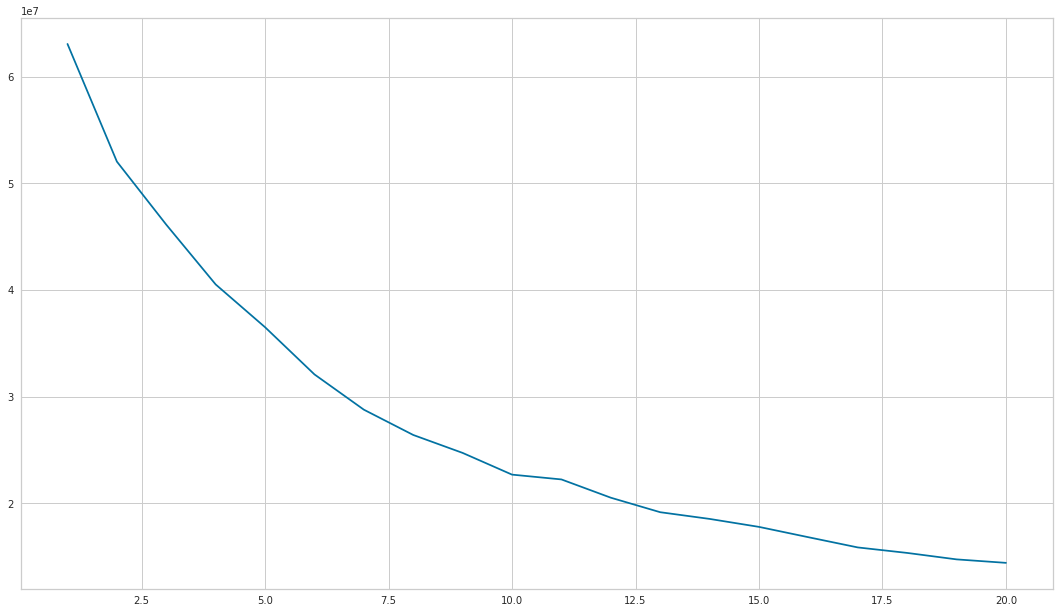

In [73]:
from matplotlib.pyplot import gcf
sum_of_sq_errs = [(key, val.inertia_) for key, val in km_models.items()]
sum_of_sq_errs = zip(*sum_of_sq_errs)
fig = gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(*sum_of_sq_errs)

## Number of points per label for each kmeans model (From 1 to 20)

In [74]:
for key, val in km_models.items():
    print(f'\nThe {key}-cluster model has the clusters:')
    arr = np.array(val.labels_)
    u, c = np.unique(arr, return_counts = True)
    print(u,'\nThe corresponding counts are:\n', c)


The 1-cluster model has the clusters:
[0] 
The corresponding counts are:
 [1040548]

The 2-cluster model has the clusters:
[0 1] 
The corresponding counts are:
 [247684 792864]

The 3-cluster model has the clusters:
[0 1 2] 
The corresponding counts are:
 [745928 238368  56252]

The 4-cluster model has the clusters:
[0 1 2 3] 
The corresponding counts are:
 [   268 787486  51623 201171]

The 5-cluster model has the clusters:
[0 1 2 3 4] 
The corresponding counts are:
 [199461 344984 444389  51446    268]

The 6-cluster model has the clusters:
[0 1 2 3 4 5] 
The corresponding counts are:
 [199529 338830 408372  46402    268  47147]

The 7-cluster model has the clusters:
[0 1 2 3 4 5 6] 
The corresponding counts are:
 [407356  83245    256 338827  47500     13 163351]

The 8-cluster model has the clusters:
[0 1 2 3 4 5 6 7] 
The corresponding counts are:
 [408361  47040  43592 338854    256     13 199539   2893]

The 9-cluster model has the clusters:
[0 1 2 3 4 5 6 7 8] 
The correspondi